# 1. Loading Dataset

The necessary Libraries were placed into one cell for simplicity rather than having to load them in specfic sections below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from IPython.display import display
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
file_path = "G:/UWI Work/Thesis/thesis data cleaning/d03_text_station_hour_2025_01.txt"  
df_station = pd.read_csv(file_path, header=None)

In [3]:
print(df_station.head())

                    0       1   2   3  4   5      6    7    8      9   ...  \
0  01/01/2025 00:00:00  308511   3  50  E  ML  3.134  198  100    5.0  ...   
1  01/01/2025 00:00:00  308512   3  50  W  ML  3.995  170    0  760.0  ...   
2  01/01/2025 00:00:00  311831   3   5  S  OR    NaN  100  100   34.0  ...   
3  01/01/2025 00:00:00  311832   3   5  S  FR    NaN  100  100  151.0  ...   
4  01/01/2025 00:00:00  311844   3   5  N  OR    NaN  200  100  204.0  ...   

   32  33  34  35  36  37  38  39  40  41  
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 42 columns]


After viewing the first few rows of the loaded dataset, it was observed there were 42 columns, many of which contains NaN values. The next step is to filter the number of columns according the the dataset description provided on the PeMS website. As such, the first 12 columns are retained as these correspond to the `Timestamp`, `Station ID`, `District`, `Freeway`, `Direction`, `Lane Type`, `Station Length`, `Samples`, `Observed Percentage`, `Total Flow` , `Average Occupancy`, and `Average Speed`.

In [4]:
df_station = df_station.iloc[:, :12]

print(df_station.head())

                    0       1   2   3  4   5      6    7    8      9       10  \
0  01/01/2025 00:00:00  308511   3  50  E  ML  3.134  198  100    5.0  0.0002   
1  01/01/2025 00:00:00  308512   3  50  W  ML  3.995  170    0  760.0  0.0344   
2  01/01/2025 00:00:00  311831   3   5  S  OR    NaN  100  100   34.0     NaN   
3  01/01/2025 00:00:00  311832   3   5  S  FR    NaN  100  100  151.0     NaN   
4  01/01/2025 00:00:00  311844   3   5  N  OR    NaN  200  100  204.0     NaN   

     11  
0  66.2  
1  63.6  
2   NaN  
3   NaN  
4   NaN  


Confirming that the first 12 columns have been filterd, the column names had to be formatted to match the dataset's description along with the timestamps being set to standard `datetime` format

In [5]:
df_station.columns = [
    "Timestamp", "Station_ID", "District", "Freeway", "Direction", "Lane_Type",
    "Station_Length", "Samples", "Observed_Percentage", "Total_Flow",
    "Avg_Occupancy", "Avg_Speed"]

df_station["Timestamp"] = pd.to_datetime(df_station["Timestamp"], errors='coerce')

print(df_station.head())

   Timestamp  Station_ID  District  Freeway Direction Lane_Type  \
0 2025-01-01      308511         3       50         E        ML   
1 2025-01-01      308512         3       50         W        ML   
2 2025-01-01      311831         3        5         S        OR   
3 2025-01-01      311832         3        5         S        FR   
4 2025-01-01      311844         3        5         N        OR   

   Station_Length  Samples  Observed_Percentage  Total_Flow  Avg_Occupancy  \
0           3.134      198                  100         5.0         0.0002   
1           3.995      170                    0       760.0         0.0344   
2             NaN      100                  100        34.0            NaN   
3             NaN      100                  100       151.0            NaN   
4             NaN      200                  100       204.0            NaN   

   Avg_Speed  
0       66.2  
1       63.6  
2        NaN  
3        NaN  
4        NaN  


Indicated in the methodology, the main dataset lacks specification on the `number of lanes` each lane type (ML, GP, OR, FR) accounts for. Hence, the metadata file was merged into the dataset as it contains this information.

In [6]:
metadata_file = "G:/UWI Work/Thesis/thesis data cleaning/d03_text_meta_2025_01_18.txt" 
df_meta = pd.read_csv(metadata_file, sep="\t") 

print(df_meta.head())

       ID  Fwy Dir  District  County  City State_PM   Abs_PM   Latitude  \
0  308511   50   E         3      17   NaN   31.627   60.162  38.761062   
1  308512   50   W         3      17   NaN   31.627   60.166  38.761182   
2  311831    5   S         3      67   NaN   10.896  506.189  38.409782   
3  311832    5   S         3      67   NaN   10.896  506.189  38.409782   
4  311844    5   N         3      67   NaN    11.08  506.373  38.412421   

    Longitude  Length Type  Lanes                        Name  User_ID_1  \
0 -120.569835   3.134   ML      2                 Sly Park Rd          1   
1 -120.569866   3.995   ML      2                 Sly Park Rd          1   
2 -121.484120     NaN   OR      1  Elk Grove Blvd to 5SB Loop          1   
3 -121.484120     NaN   FR      1       5SB to Elk Grove Blvd          1   
4 -121.484289     NaN   OR      2     Elk Grove Blvd 5NB Slip          1   

   User_ID_2  User_ID_3  User_ID_4  
0        NaN        NaN        NaN  
1        NaN      

Similar to the main dataset, we target the relevant columns, rename according to the datasets description and do so using a copy so it would not affect the main metadata file.

In [7]:
df_meta_cleaned = df_meta[["ID", "Fwy", "Dir", "Abs_PM", "Latitude", "Longitude", "Lanes"]].copy()

# Rename columns to match the PeMS data description
df_meta_cleaned.rename(columns={
    "ID": "Station_ID",
    "Fwy": "Freeway",
    "Dir": "Direction",
    "Abs_PM": "Absolute_Postmile"
}, inplace=True)

print(df_meta_cleaned.head())

   Station_ID  Freeway Direction  Absolute_Postmile   Latitude   Longitude  \
0      308511       50         E             60.162  38.761062 -120.569835   
1      308512       50         W             60.166  38.761182 -120.569866   
2      311831        5         S            506.189  38.409782 -121.484120   
3      311832        5         S            506.189  38.409782 -121.484120   
4      311844        5         N            506.373  38.412421 -121.484289   

   Lanes  
0      2  
1      2  
2      1  
3      1  
4      2  


After the columns were renamed for clarity, the two datasets were merged according to (`Station_ID`, `Freeway`, and `Direction`) to ensure the information was correctly assigned to their respective `stations`.

In [8]:
# Merge the two datasets
df_merged = df_station.merge(df_meta_cleaned, on=["Station_ID", "Freeway", "Direction"], how="left")

print(df_merged.head())

   Timestamp  Station_ID  District  Freeway Direction Lane_Type  \
0 2025-01-01      308511         3       50         E        ML   
1 2025-01-01      308512         3       50         W        ML   
2 2025-01-01      311831         3        5         S        OR   
3 2025-01-01      311832         3        5         S        FR   
4 2025-01-01      311844         3        5         N        OR   

   Station_Length  Samples  Observed_Percentage  Total_Flow  Avg_Occupancy  \
0           3.134      198                  100         5.0         0.0002   
1           3.995      170                    0       760.0         0.0344   
2             NaN      100                  100        34.0            NaN   
3             NaN      100                  100       151.0            NaN   
4             NaN      200                  100       204.0            NaN   

   Avg_Speed  Absolute_Postmile   Latitude   Longitude  Lanes  
0       66.2             60.162  38.761062 -120.569835    2.0  


# 2.Cleaning

To gain an understanding of the full dataset to be explored, identifiying how many rows had no missing data was the first step.

In [9]:
rows_without_missingvalues = df_merged.dropna().shape[0]

total = df_merged.shape[0]

percentage_of_complete_rows = (rows_without_missingvalues / total) * 100

print( f"Rows with no missing values: {rows_without_missingvalues}")
print( f"Total number of rows: {total}")
print( f"Percentage of rows with complete data: {percentage_of_complete_rows:.2f}%")

Rows with no missing values: 850930
Total number of rows: 1387848
Percentage of rows with complete data: 61.31%


In [10]:
df_merged

,Timestamp,Station_ID,District,Freeway,Direction,Lane_Type,Station_Length,Samples,Observed_Percentage,Total_Flow,Avg_Occupancy,Avg_Speed,Absolute_Postmile,Latitude,Longitude,Lanes
0,2025-01-01 00:00:00,308511,3,50,E,ML,3.134,198,100,5.0,0.0002,66.2,60.162,38.761062,-120.569835,2.0
1,2025-01-01 00:00:00,308512,3,50,W,ML,3.995,170,0,760.0,0.0344,63.6,60.166,38.761182,-120.569866,2.0
2,2025-01-01 00:00:00,311831,3,5,S,OR,NaN,100,100,34.0,NaN,NaN,506.189,38.409782,-121.484120,1.0
3,2025-01-01 00:00:00,311832,3,5,S,FR,NaN,100,100,151.0,NaN,NaN,506.189,38.409782,-121.484120,1.0
4,2025-01-01 00:00:00,311844,3,5,N,OR,NaN,200,100,204.0,NaN,NaN,506.373,38.412421,-121.484289,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387843,2025-01-31 23:00:00,3423094,3,99,S,ML,0.567,117,88,27.0,0.0013,63.1,381.568,39.771609,-121.869963,2.0
1387844,2025-01-31 23:00:00,3900021,3,50,E,ML,0.007,0,0,882.0,0.0296,64.4,18.130,38.608682,-121.270954,3.0
1387845,2025-01-31 23:00:00,3900022,3,50,E,HV,0.000,0,0,789.0,0.0359,68.1,18.130,38.608682,-121.270954,1.0
1387846,2025-01-31 23:00:00,3900023,3,50,W,ML,0.019,0,0,908.0,0.0295,64.3,18.130,38.608894,-121.271067,3.0


The next step is to observe what columns contained missing values and how many rows were affected. This will allow us to see which features need to be cleaned.

In [11]:
print(df_merged.isnull().sum())

Timestamp                   0
Station_ID                  0
District                    0
Freeway                     0
Direction                   0
Lane_Type                   0
Station_Length         535776
Samples                     0
Observed_Percentage         0
Total_Flow              98070
Avg_Occupancy          523948
Avg_Speed              535776
Absolute_Postmile         446
Latitude                 1934
Longitude                1934
Lanes                     446
dtype: int64


We drop the  `Absolute_Postmile`, `Latitude`, `Longitude`, and `Lanes` rows as they have less that 1% of missing data and wont affect the dataset.

In [12]:
df_merged.dropna(subset=["Absolute_Postmile", "Latitude", "Longitude", "Lanes"], inplace=True)

In [13]:
print(df_merged.isnull().sum())

Timestamp                   0
Station_ID                  0
District                    0
Freeway                     0
Direction                   0
Lane_Type                   0
Station_Length         534984
Samples                     0
Observed_Percentage         0
Total_Flow              98070
Avg_Occupancy          523156
Avg_Speed              534984
Absolute_Postmile           0
Latitude                    0
Longitude                   0
Lanes                       0
dtype: int64


Before applying cleaning steps to `Station Length`, `Total Flow`, `Average Occupancy`, and `Average Speed`, observing the distribution of those features will be helpful as a reference to see how the shape changes after cleaning steps have been applied

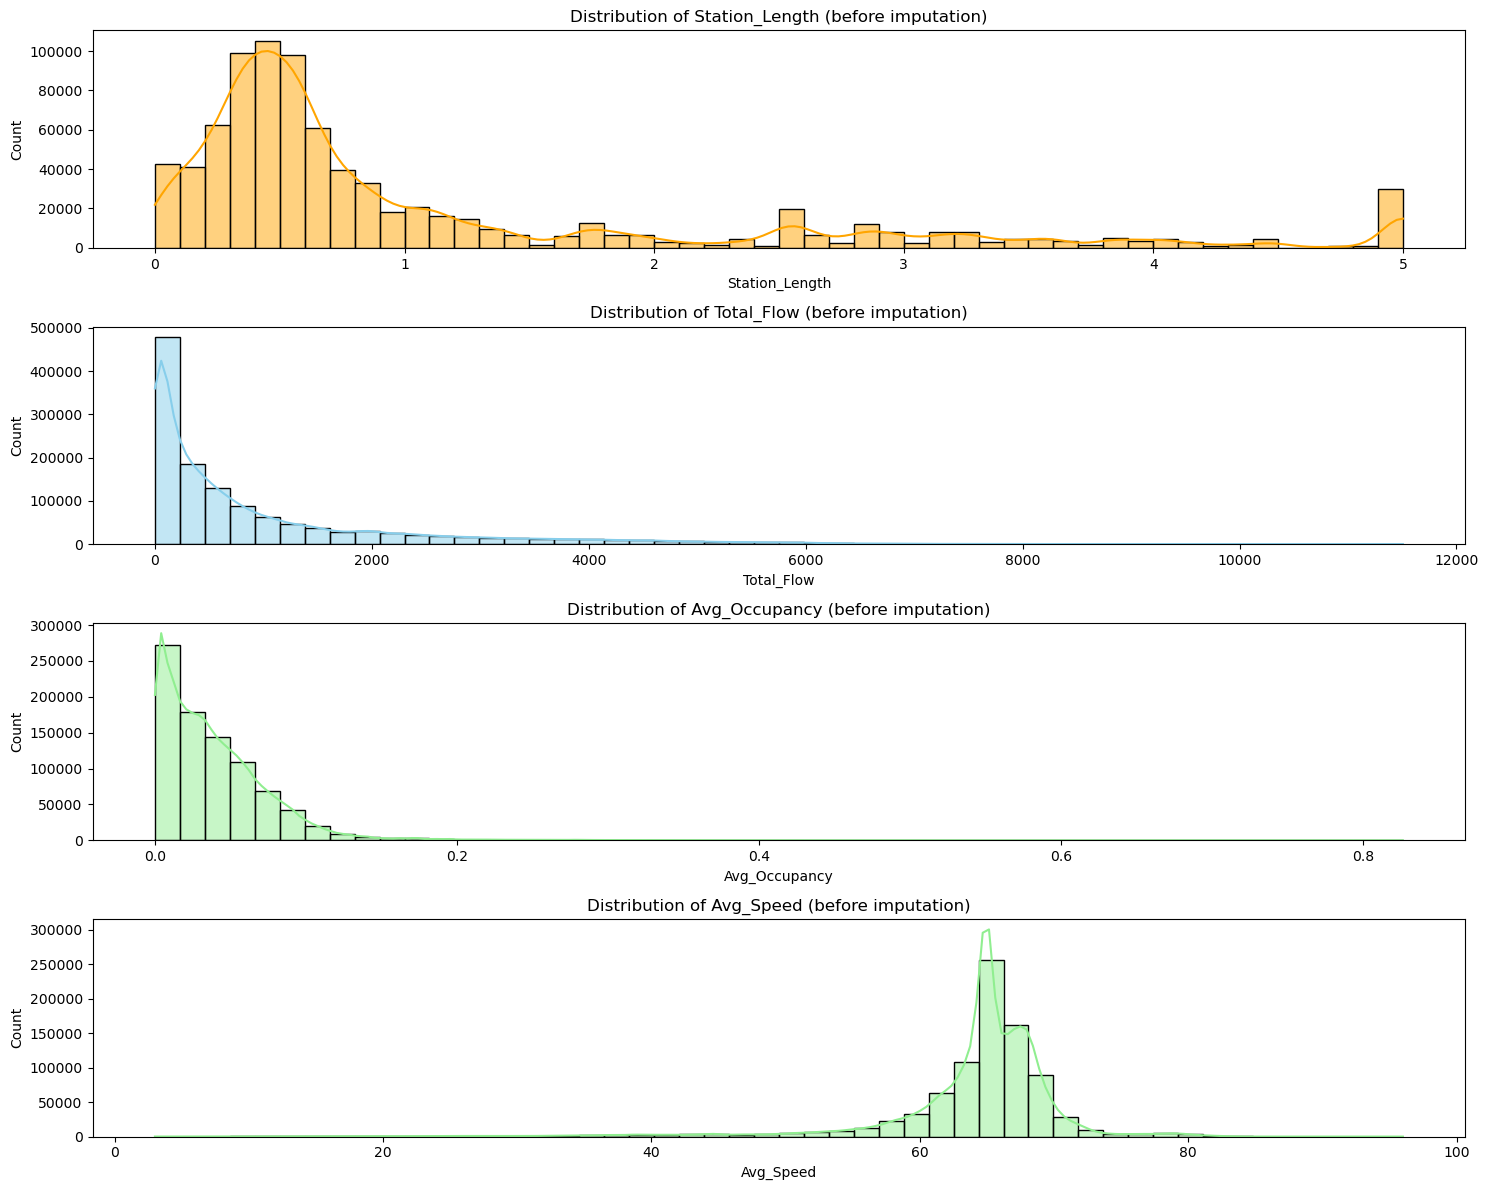

In [14]:
# Plotting the distributions
plt.figure(figsize=(15, 12))

# 1. Station_Length
plt.subplot(4, 1, 1)
sns.histplot(df_merged["Station_Length"].dropna(), bins=50, kde=True, color='orange')
plt.title("Distribution of Station_Length (before imputation)")
plt.xlabel("Station_Length")
plt.ylabel("Count")

# 2. Total_Flow
plt.subplot(4, 1, 2)
sns.histplot(df_merged["Total_Flow"].dropna(), bins=50, kde=True, color='skyblue')
plt.title("Distribution of Total_Flow (before imputation)")
plt.xlabel("Total_Flow")
plt.ylabel("Count")

# 3. Avg_Occupancy
plt.subplot(4, 1, 3)
sns.histplot(df_merged["Avg_Occupancy"].dropna(), bins=50, kde=True, color='lightgreen')
plt.title("Distribution of Avg_Occupancy (before imputation)")
plt.xlabel("Avg_Occupancy")
plt.ylabel("Count")

# 4. Avg_Speed
plt.subplot(4, 1, 4)
sns.histplot(df_merged["Avg_Speed"].dropna(), bins=50, kde=True, color='lightgreen')
plt.title("Distribution of Avg_Speed (before imputation)")
plt.xlabel("Avg_Speed")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

For the columns with missing rows of data, imputation will be done using medians. Medians are used to reduce bias.

- For `Station Length`,the median imputation is done based of the specific freeway and its location along that freeway using their respective postmile value. This aims at reducing generalization and uses a more targeted method of imputation. As a precaution, if there were still Station lengths with NaN values, they were fitted with the overall median of Station Length.
- Similar to the imputation process that was done for `Station length`, imputation using median values were done for `Total Flow` and `Average Occupancy` with respect to the Freeway number.
- `Average Speed` had a more nuanced approach of imputation, guided by traffic flow theory. Here, where there is 0 flow observed, the resulting `average speed` should be set to zero but in other cases of where flow is detected, the missing data is imputed with the overall median with respect to the Freeway number.

In [15]:
df_merged["Station_Length"] = df_merged.groupby(["Freeway", "Absolute_Postmile"])["Station_Length"].transform(lambda x: x.fillna(x.median()))

# If some groups had only NaNs, fill with overall median
df_merged["Station_Length"] = df_merged["Station_Length"].fillna(df_merged["Station_Length"].median())

In [16]:
df_merged["Total_Flow"] = df_merged.groupby("Freeway")["Total_Flow"].transform(lambda x: x.fillna(x.median()))

In [17]:
df_merged["Avg_Occupancy"] = df_merged.groupby("Freeway")["Avg_Occupancy"].transform(lambda x: x.fillna(x.median()))

In [18]:
# If Total_Flow is 0, set Avg_Speed to 0
df_merged.loc[df_merged["Total_Flow"] == 0, "Avg_Speed"] = 0

# If Total_Flow > 0 but Avg_Speed is missing, use median speed per freeway
df_merged["Avg_Speed"] = df_merged.groupby("Freeway")["Avg_Speed"].transform(lambda x: x.fillna(x.median()))


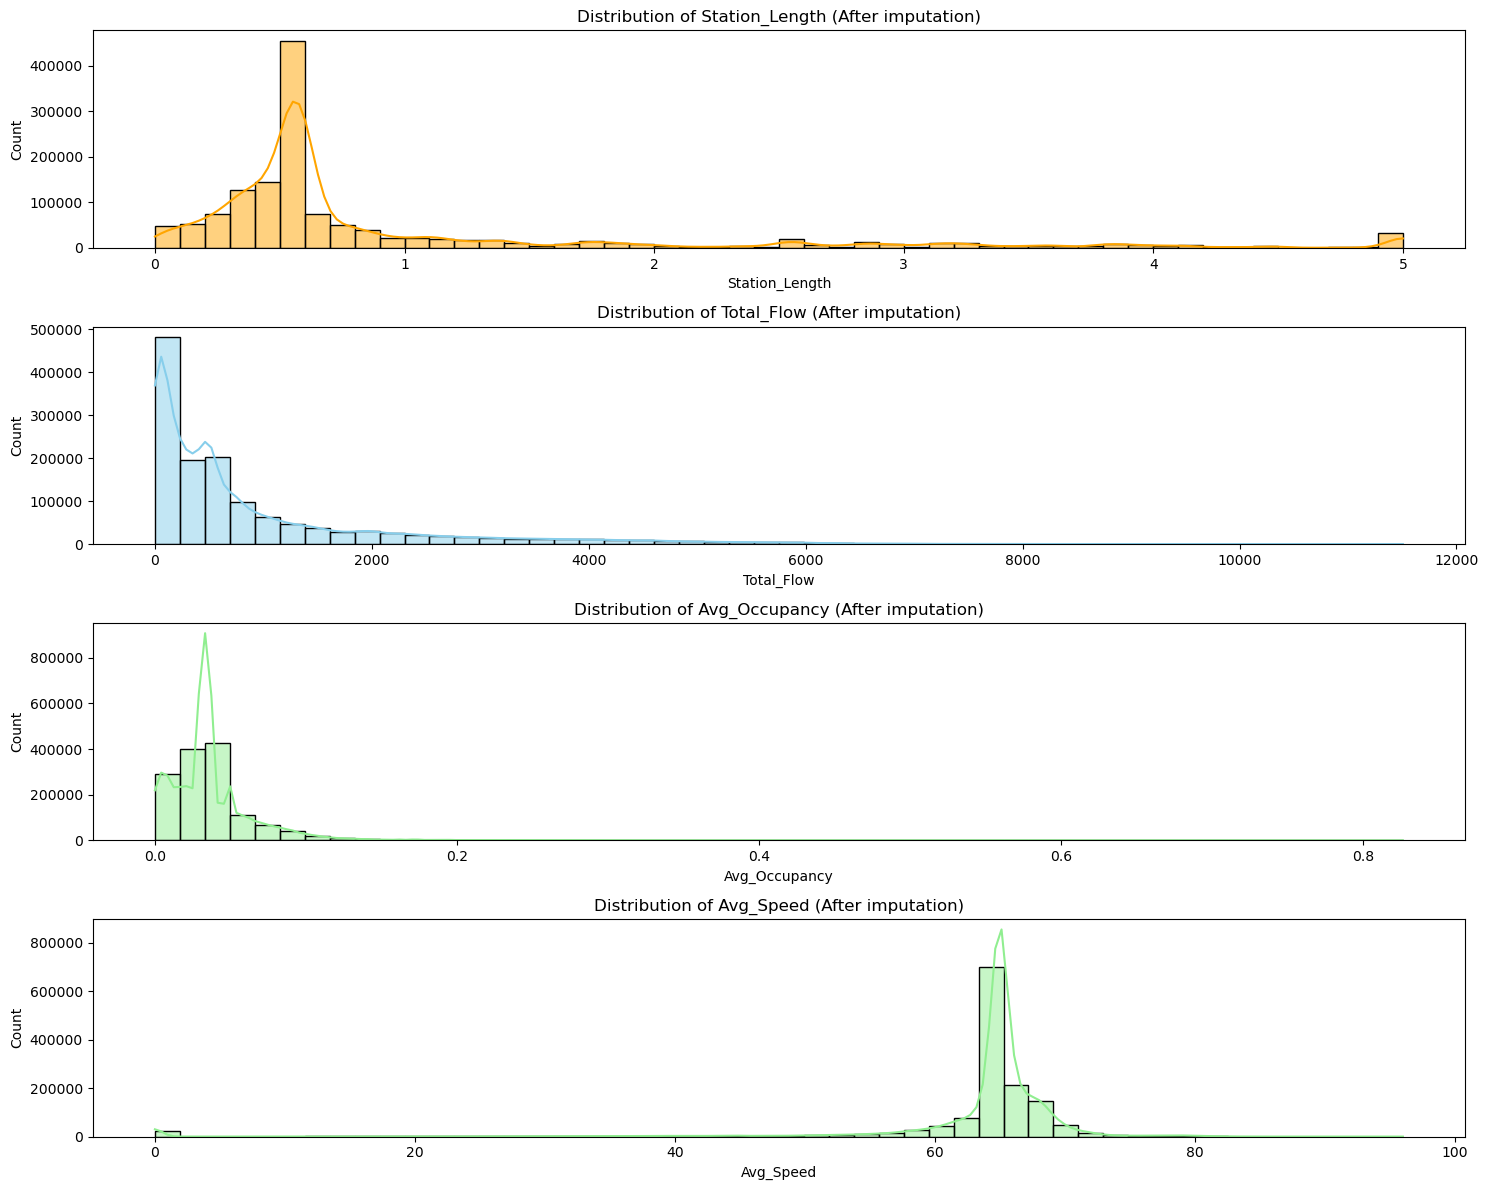

In [19]:
# Plotting the distributions
plt.figure(figsize=(15, 12))

# 1. Station_Length
plt.subplot(4, 1, 1)
sns.histplot(df_merged["Station_Length"].dropna(), bins=50, kde=True, color='orange')
plt.title("Distribution of Station_Length (After imputation)")
plt.xlabel("Station_Length")
plt.ylabel("Count")

# 2. Total_Flow
plt.subplot(4, 1, 2)
sns.histplot(df_merged["Total_Flow"].dropna(), bins=50, kde=True, color='skyblue')
plt.title("Distribution of Total_Flow (After imputation)")
plt.xlabel("Total_Flow")
plt.ylabel("Count")

# 3. Avg_Occupancy
plt.subplot(4, 1, 3)
sns.histplot(df_merged["Avg_Occupancy"].dropna(), bins=50, kde=True, color='lightgreen')
plt.title("Distribution of Avg_Occupancy (After imputation)")
plt.xlabel("Avg_Occupancy")
plt.ylabel("Count")

# 4. Avg_Speed
plt.subplot(4, 1, 4)
sns.histplot(df_merged["Avg_Speed"].dropna(), bins=50, kde=True, color='lightgreen')
plt.title("Distribution of Avg_Speed (After imputation)")
plt.xlabel("Avg_Speed")
plt.ylabel("Count")


plt.tight_layout()
plt.show()

Observing the distribution of the features after targetd imputation, the overall shape has been maintained indicating that no significant bias has been introduced to the dataset and the process was successful. 
- `Station Length` and `Average Occupancy` had the most missing data but after imputation the initial shape is preserved with the peak centralized around the median.
- `Total Flow` maintained the right-skewed distribution but now with the missing values filled in with the targeted medians.
-  `Average Speed` now correctly indicated where there was no flow, speed in 0 revealing the potential cases of traffic jam or off peak hours where there is no cars flowing. 

In [20]:
print(df_merged.isnull().sum())

Timestamp                 0
Station_ID                0
District                  0
Freeway                   0
Direction                 0
Lane_Type                 0
Station_Length            0
Samples                   0
Observed_Percentage       0
Total_Flow                0
Avg_Occupancy          1488
Avg_Speed              1488
Absolute_Postmile         0
Latitude                  0
Longitude                 0
Lanes                     0
dtype: int64


Although most missing values were successfully imputed, a small number (1,488 rows) still remained in the `Avg_Occupancy` and `Avg_Speed` columns. Since this represents less than 0.1% of the total dataset, these rows were removed as this action is unlikely to affect the overall distributions.

In [21]:
df_merged = df_merged.dropna()
print(df_merged.isnull().sum())

Timestamp              0
Station_ID             0
District               0
Freeway                0
Direction              0
Lane_Type              0
Station_Length         0
Samples                0
Observed_Percentage    0
Total_Flow             0
Avg_Occupancy          0
Avg_Speed              0
Absolute_Postmile      0
Latitude               0
Longitude              0
Lanes                  0
dtype: int64


# 3. Feature Engineering and EDA

Since the dataset did not include the distance between stations, this was computed using the `Absolute_Postmile` field, which represents how far along a freeway each station is located, in miles. 

In [22]:
print(df_merged[["Freeway", "Absolute_Postmile"]])

         Freeway  Absolute_Postmile
0             50             60.162
1             50             60.166
2              5            506.189
3              5            506.189
4              5            506.373
...          ...                ...
1387843       99            381.568
1387844       50             18.130
1387845       50             18.130
1387846       50             18.130
1387847       50             18.130

[1384426 rows x 2 columns]


As a precaution, the `Freeway` and `Absolute Postmile` columns were checked for missing data

In [23]:
print(df_merged[["Freeway", "Absolute_Postmile"]].isnull().sum())

Freeway              0
Absolute_Postmile    0
dtype: int64


- Duplicate station records can affect the calculation as multiple instances of the same station can result in zero values. Hence, any repeated combinations of `Freeway` and `Postmile` values were removed, retaining only the first occurrence.
- The data was then sorted so that `stations` appeared in the correct order along each `freeway`, from the lowest to the highest `post-mile`, ensuring that each station’s position reflected its actual position on the freeway.

In [24]:
# Remove duplicate Freeway & Absolute_Postmile pairs but the keep first occurrence
df_unique_stations = df_merged.drop_duplicates(subset=["Freeway", "Absolute_Postmile"])

# Ensure they are ordered   
df_unique_stations = df_unique_stations.sort_values(by=["Freeway", "Absolute_Postmile"])

# Check if the duplicates have been removed
print(df_unique_stations[["Freeway", "Absolute_Postmile"]].duplicated().sum()) 

0


- Once the data was ordered, the distance between each `station` and the one before it was calculated along the same `freeway`. This gave the distance in miles, which was then converted to meters by multiplying by `1609.34`. The resulting values were stored in a new column labelled `Distance_m`.
- For the first station in each freeway, the result was a missing value as they were considered to be the starting point and were set to `zero`.

In [25]:
# Compute distance between consecutive stations
df_unique_stations["Distance_m"] = df_unique_stations.groupby("Freeway")["Absolute_Postmile"].diff() * 1609.34

# Fill missing values for first station with zero
df_unique_stations["Distance_m"] = df_unique_stations["Distance_m"].fillna(0)

print(df_unique_stations[["Freeway", "Absolute_Postmile", "Distance_m"]])

      Freeway  Absolute_Postmile   Distance_m
1734        5            497.212      0.00000
1736        5            497.213      1.60934
1737        5            497.319    170.59004
670         5            504.791  12024.98848
2           5            506.189   2249.85732
...       ...                ...          ...
988       267              8.539  10216.09032
281       275              0.151      0.00000
487       275              0.153      3.21868
1540      505             10.674      0.00000
1541      505             10.680      9.65604

[1383 rows x 3 columns]


Now that the distances covered by the stations have been computed, they will be merged back to the main dataset with respect to their `freeway number` and `station loaction` on the freeway. This ensures that the `distances` are correctly assigned to the specific `Stations`.

In [26]:
# Merge corrected Distance_m back into full dataset
df_merged = df_merged.merge(
    df_unique_stations[["Freeway", "Absolute_Postmile", "Distance_m"]],
    on=["Freeway", "Absolute_Postmile"],
    how="left"
)

print(df_merged[["Freeway", "Absolute_Postmile", "Distance_m"]])

         Freeway  Absolute_Postmile  Distance_m
0             50             60.162  2042.25246
1             50             60.166     6.43736
2              5            506.189  2249.85732
3              5            506.189  2249.85732
4              5            506.373   222.08892
...          ...                ...         ...
1384421       99            381.568  1818.55420
1384422       50             18.130     1.60934
1384423       50             18.130     1.60934
1384424       50             18.130     1.60934
1384425       50             18.130     1.60934

[1384426 rows x 3 columns]


To calcualte the `Travel Time` in seconds, we needed to use the `Average Speed` and the `Distance` metric which was just computed.
- `Average Speed` was in `Miles per Hour` so this needed to be converted to `meters per second`, multiplying by `0.44704`.
- As there are zero values in the dataset, a precautionary step is taken to avoid any issues.

In [27]:
# Convert speed from mph to m/s
df_merged["Speed_mps"] = df_merged["Avg_Speed"] * 0.44704

# Compute travel time 
df_merged["Travel_Time_s"] = df_merged["Distance_m"] / df_merged["Speed_mps"]

# avoid division by zero
df_merged["Travel_Time_s"].replace([float("inf"), -float("inf")], 0, inplace=True)
df_merged["Travel_Time_s"].fillna(0, inplace=True)

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\295084470.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Travel_Time_s"].replace([float("inf"), -float("inf")], 0, inplace=True)
C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\295084470.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [28]:
print(df_merged.isnull().sum())


Timestamp              0
Station_ID             0
District               0
Freeway                0
Direction              0
Lane_Type              0
Station_Length         0
Samples                0
Observed_Percentage    0
Total_Flow             0
Avg_Occupancy          0
Avg_Speed              0
Absolute_Postmile      0
Latitude               0
Longitude              0
Lanes                  0
Distance_m             0
Speed_mps              0
Travel_Time_s          0
dtype: int64


We confimed that the conversions were successfully placed into their own columns above, however, we are specifically targeting `ML` lane types so the next step is to exclude all other lane types from the dataset.
Other lane types such as `FR` (Freeway Ramps), `HV` (High-Occupancy Vehicle lanes), and `OR` (On/Off-Ramps) are not relevant for this analysis. 

In [29]:
print(df_merged.dtypes)


Timestamp              datetime64[ns]
Station_ID                      int64
District                        int64
Freeway                         int64
Direction                      object
Lane_Type                      object
Station_Length                float64
Samples                         int64
Observed_Percentage             int64
Total_Flow                    float64
Avg_Occupancy                 float64
Avg_Speed                     float64
Absolute_Postmile             float64
Latitude                      float64
Longitude                     float64
Lanes                         float64
Distance_m                    float64
Speed_mps                     float64
Travel_Time_s                 float64
dtype: object


The categorical variables `Lane_Type` and `Direction` were converted to dummy variables using one-hot encoding.
- The dataset was filtered to retain only rows where `Lane_Type_ML` was `True`.
- All other dummy columns related to alternative lane types were removed.

In [30]:
df_merged = pd.get_dummies(df_merged, columns=["Lane_Type", "Direction"], drop_first=True)

In [31]:
print(df_merged.dtypes)

Timestamp              datetime64[ns]
Station_ID                      int64
District                        int64
Freeway                         int64
Station_Length                float64
Samples                         int64
Observed_Percentage             int64
Total_Flow                    float64
Avg_Occupancy                 float64
Avg_Speed                     float64
Absolute_Postmile             float64
Latitude                      float64
Longitude                     float64
Lanes                         float64
Distance_m                    float64
Speed_mps                     float64
Travel_Time_s                 float64
Lane_Type_FR                     bool
Lane_Type_HV                     bool
Lane_Type_ML                     bool
Lane_Type_OR                     bool
Direction_N                      bool
Direction_S                      bool
Direction_W                      bool
dtype: object


In [32]:
df_merged = df_merged[df_merged["Lane_Type_ML"] == True]
df_merged.drop(columns=["Lane_Type_FR", "Lane_Type_HV", "Lane_Type_OR"], inplace=True)

In [33]:
print(df_merged.dtypes)

Timestamp              datetime64[ns]
Station_ID                      int64
District                        int64
Freeway                         int64
Station_Length                float64
Samples                         int64
Observed_Percentage             int64
Total_Flow                    float64
Avg_Occupancy                 float64
Avg_Speed                     float64
Absolute_Postmile             float64
Latitude                      float64
Longitude                     float64
Lanes                         float64
Distance_m                    float64
Speed_mps                     float64
Travel_Time_s                 float64
Lane_Type_ML                     bool
Direction_N                      bool
Direction_S                      bool
Direction_W                      bool
dtype: object


The dataset succesfully accounts for only `ML lane types` now.

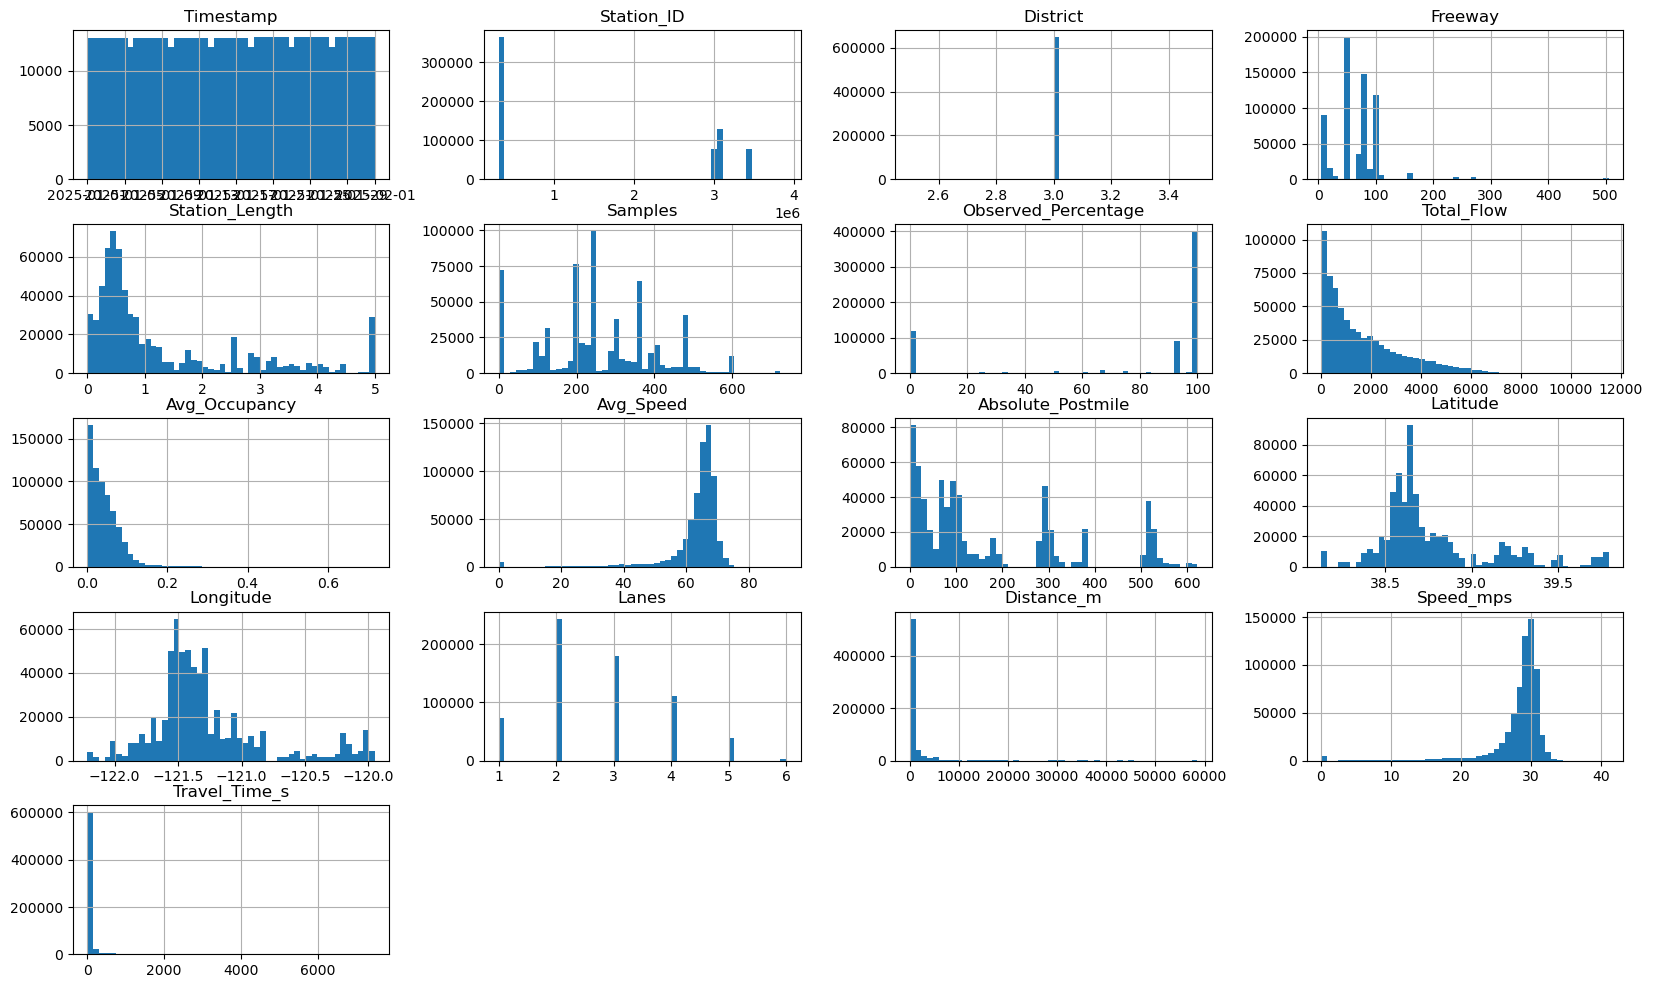

In [34]:
df_merged.hist(figsize=(20, 12), bins=50)
plt.show()


count    647890.000000
mean          2.700394
std           1.086794
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: Lanes, dtype: float64
Lanes
2.0    244368
3.0    179650
4.0    110448
1.0     72504
5.0     37944
6.0      2976
Name: count, dtype: int64


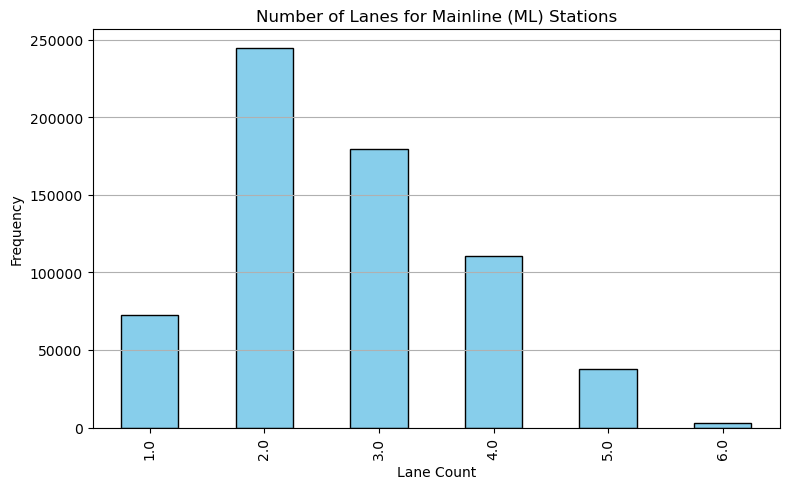

In [35]:
# Summary statistics
print(df_merged["Lanes"].describe())

# lane counts and frequencies
print(df_merged["Lanes"].value_counts())

plt.figure(figsize=(8,5))
df_merged["Lanes"].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Lanes for Mainline (ML) Stations")
plt.xlabel("Lane Count")
plt.ylabel("Frequency")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


The above histogram lays out the distribution of the lane count accounted for in ML segments. As `2, 3, and 4 lane ML segments` make up the majority of this dataset, these are the configurations that will be focused on.

In [36]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647890 entries, 0 to 1384424
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Timestamp            647890 non-null  datetime64[ns]
 1   Station_ID           647890 non-null  int64         
 2   District             647890 non-null  int64         
 3   Freeway              647890 non-null  int64         
 4   Station_Length       647890 non-null  float64       
 5   Samples              647890 non-null  int64         
 6   Observed_Percentage  647890 non-null  int64         
 7   Total_Flow           647890 non-null  float64       
 8   Avg_Occupancy        647890 non-null  float64       
 9   Avg_Speed            647890 non-null  float64       
 10  Absolute_Postmile    647890 non-null  float64       
 11  Latitude             647890 non-null  float64       
 12  Longitude            647890 non-null  float64       
 13  Lanes             

After cleaning and feature engineering, we were able to retain `647,890` rows, which is still a significant number of recordings.

In [37]:
display(df_merged.describe())

,Timestamp,Station_ID,District,Freeway,Station_Length,Samples,Observed_Percentage,Total_Flow,Avg_Occupancy,Avg_Speed,Absolute_Postmile,Latitude,Longitude,Lanes,Distance_m,Speed_mps,Travel_Time_s
count,647890,6.478900e+05,647890.0,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000,647890.000000
mean,2025-01-16 11:55:25.181125632,1.561312e+06,3.0,65.771316,1.252357,253.503783,78.515345,1623.560850,0.042673,63.526688,168.609429,38.771925,-121.283566,2.700394,1393.815898,28.398971,49.554055
min,2025-01-01 00:00:00,3.085110e+05,3.0,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111000,38.129763,-122.214892,1.000000,0.000000,0.000000,0.000000
25%,2025-01-08 18:00:00,3.160950e+05,3.0,50.000000,0.394000,190.000000,92.000000,405.000000,0.013900,62.700000,32.297000,38.574212,-121.529285,2.000000,11.265380,28.029408,0.358208
50%,2025-01-16 12:00:00,3.191420e+05,3.0,65.000000,0.638000,240.000000,100.000000,1107.000000,0.034200,65.600000,95.877000,38.657908,-121.395078,3.000000,72.420300,29.325824,2.462535
75%,2025-01-24 06:00:00,3.064082e+06,3.0,80.000000,1.708000,360.000000,100.000000,2425.000000,0.061100,67.700000,292.742000,38.858548,-121.173122,3.000000,642.126660,30.264608,23.191743
max,2025-01-31 23:00:00,3.900023e+06,3.0,505.000000,5.000000,738.000000,100.000000,11506.000000,0.717900,92.000000,621.401000,39.789571,-119.949361,6.000000,58531.695800,41.127680,7494.555285
std,NaN,1.413450e+06,0.0,43.159036,1.334184,146.302200,38.341733,1548.126105,0.039132,8.881555,171.014070,0.330775,0.445541,1.086794,5161.864812,3.970410,182.263279


## 3.1 Inspecting Zero Values
- Gudied by `Traffic Flow Theory`, Key features were evaluated for zero counts to ensure their validity.

In [38]:
zero_counts = (df_merged == 0).sum()
print(zero_counts)

Timestamp                   0
Station_ID                  0
District                    0
Freeway                     0
Station_Length            744
Samples                 71951
Observed_Percentage    117515
Total_Flow               4619
Avg_Occupancy            4870
Avg_Speed                4619
Absolute_Postmile           0
Latitude                    0
Longitude                   0
Lanes                       0
Distance_m              16368
Speed_mps                4619
Travel_Time_s           20237
Lane_Type_ML                0
Direction_N            506530
Direction_S            500232
Direction_W            470818
dtype: int64


After inspecting the columns that have Zero counts, there were rows where zeros can be plausable while others were not. for example:
- `Distance_m` represents the coverage of a specific sensor station, and `Station_Length` indicates segment length, rows where either of these variables equaled zero were removed
- Zero values in `traffic flow` metrics can be valid in cases such as during off-peak hours when traffic flow is low or when congestion reaches its maximum during peak hours. 

In [39]:
df_merged["Hour"] = df_merged["Timestamp"].dt.hour
df_merged["Day_of_Week"] = df_merged["Timestamp"].dt.dayofweek

This was done so we may inspect at what hours the zero values occured for traffic flow metrics

In [40]:
# Remove rows where the station length and distance is zero
df_merged = df_merged[(df_merged["Distance_m"] != 0) & (df_merged["Station_Length"] != 0)]

In [41]:
zero_counts = (df_merged == 0).sum()
print(zero_counts)

Timestamp                   0
Station_ID                  0
District                    0
Freeway                     0
Station_Length              0
Samples                 68815
Observed_Percentage    112747
Total_Flow               3869
Avg_Occupancy            4120
Avg_Speed                3869
Absolute_Postmile           0
Latitude                    0
Longitude                   0
Lanes                       0
Distance_m                  0
Speed_mps                3869
Travel_Time_s            3869
Lane_Type_ML                0
Direction_N            493882
Direction_S            485352
Direction_W            460402
Hour                    26282
Day_of_Week             81408
dtype: int64


In [42]:
# Traffic flow metrics to inspect
Traffic_flow_metrics = ["Total_Flow", "Avg_Speed", "Speed_mps", "Travel_Time_s"]

# Identify the zero values occurance by hour
for col in Traffic_flow_metrics:
    print(f"\n Zero values in {col}")
    zero_rows = df_merged[df_merged[col] == 0]
    hourly_counts = zero_rows.groupby("Hour").size()
    print(hourly_counts.sort_index())



 Zero values in Total_Flow
Hour
0     426
1     681
2     686
3     562
4     386
5     163
6      54
7      36
8      23
9      37
10     34
11     45
12     24
13     33
14     26
15     18
16     10
17     17
18     41
19     52
20     48
21     65
22    135
23    267
dtype: int64

 Zero values in Avg_Speed
Hour
0     426
1     681
2     686
3     562
4     386
5     163
6      54
7      36
8      23
9      37
10     34
11     45
12     24
13     33
14     26
15     18
16     10
17     17
18     41
19     52
20     48
21     65
22    135
23    267
dtype: int64

 Zero values in Speed_mps
Hour
0     426
1     681
2     686
3     562
4     386
5     163
6      54
7      36
8      23
9      37
10     34
11     45
12     24
13     33
14     26
15     18
16     10
17     17
18     41
19     52
20     48
21     65
22    135
23    267
dtype: int64

 Zero values in Travel_Time_s
Hour
0     426
1     681
2     686
3     562
4     386
5     163
6      54
7      36
8      23
9      37
10     3

zero values in the traffic flow variables: `Total_Flow`, `Avg_Speed`, `Speed_mps`, and `Travel_Time_s` were retained:
- zero values mostly occurred during off-peak hours, while a smaller number occurred during peak times.
- They also represented roughly 0.6% of the dataset hence they were retained 

In [43]:
df_merged = df_merged.drop(columns=[
    "Samples", "Observed_Percentage",
    "Direction_N", "Direction_S", "Direction_W"
])

zero_counts = (df_merged == 0).sum()
print(zero_counts)

Timestamp                0
Station_ID               0
District                 0
Freeway                  0
Station_Length           0
Total_Flow            3869
Avg_Occupancy         4120
Avg_Speed             3869
Absolute_Postmile        0
Latitude                 0
Longitude                0
Lanes                    0
Distance_m               0
Speed_mps             3869
Travel_Time_s         3869
Lane_Type_ML             0
Hour                 26282
Day_of_Week          81408
dtype: int64


These features were not being used in the analysis so they were dropped from the dataset. Hence, the only zero values retained were for the `traffic flow variables` that aligned with `traffic flow theory` 

In [44]:
df_merged.info

<bound method DataFrame.info of                   Timestamp  Station_ID  District  Freeway  Station_Length  \
0       2025-01-01 00:00:00      308511         3       50           3.134   
1       2025-01-01 00:00:00      308512         3       50           3.995   
7       2025-01-01 00:00:00      311903         3       50           0.883   
10      2025-01-01 00:00:00      311974         3       50           0.466   
12      2025-01-01 00:00:00      312010         3       50           0.752   
...                     ...         ...       ...      ...             ...   
1384417 2025-01-31 23:00:00     3423064         3       99           2.888   
1384420 2025-01-31 23:00:00     3423091         3       99           1.036   
1384421 2025-01-31 23:00:00     3423094         3       99           0.567   
1384422 2025-01-31 23:00:00     3900021         3       50           0.007   
1384424 2025-01-31 23:00:00     3900023         3       50           0.019   

         Total_Flow  Avg_Occupa

In [45]:
print("Available features in df_merged:")
print(df_merged.columns.tolist())

Available features in df_merged:
['Timestamp', 'Station_ID', 'District', 'Freeway', 'Station_Length', 'Total_Flow', 'Avg_Occupancy', 'Avg_Speed', 'Absolute_Postmile', 'Latitude', 'Longitude', 'Lanes', 'Distance_m', 'Speed_mps', 'Travel_Time_s', 'Lane_Type_ML', 'Hour', 'Day_of_Week']


## 3.2 Converting Metrics

Moving onto the preliminary steps to create the plots so we may analyze the relationships between the traffic flow metrics:
- `Speed` needed to be standardized to local metrics  such as kilometer per hour
- `travel time` was standardized to per kilometer for a more consistent comparison across segments
- The `Density` feature was created so we may analyze how speed and travel time behave at specific density levels.

In [46]:
# Convert speed to km/h from m/s
df_merged["Speed_kph"] = df_merged["Speed_mps"] * 3.6

# Avoid division by zero
df_merged = df_merged[df_merged["Speed_kph"] > 0]

# Calculate vehicle density (Vehicles per KM)
df_merged["Vehicles_per_KM"] = df_merged["Total_Flow"] / df_merged["Speed_kph"]

# Calculate Travel Time per KM (seconds per KM)
df_merged["Travel_Time_per_KM"] = df_merged["Travel_Time_s"] / (df_merged["Distance_m"] / 1000)


C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\4081487628.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Vehicles_per_KM"] = df_merged["Total_Flow"] / df_merged["Speed_kph"]
C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\4081487628.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Travel_Time_per_KM"] = df_merged["Travel_Time_s"] / (df_merged["Distance_m"] / 1000)


## 3.3 EDA
This was done to visualize the data's distribution after cleaning.
- histograms and boxplots were generated for `travel time`, `speed`, `total flow`, and `distance` covered by station sensors. 

These plots helped visualize the traffic patterns captured by the dataset.

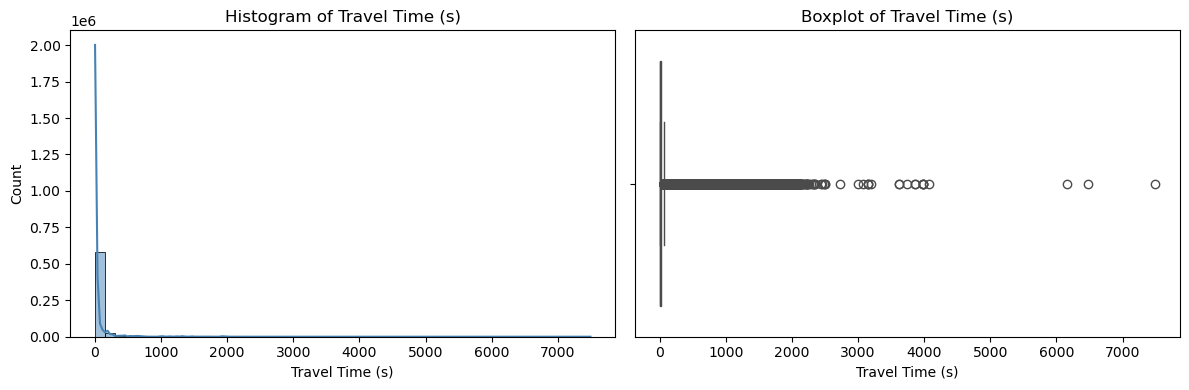

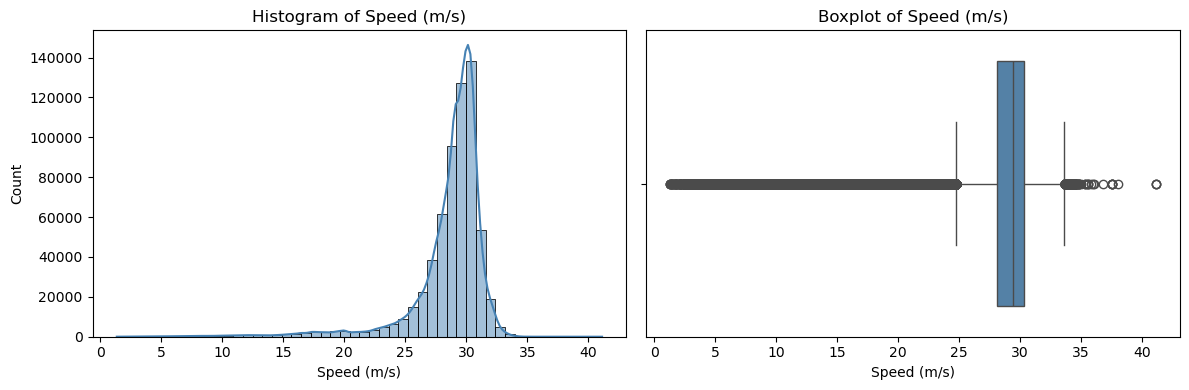

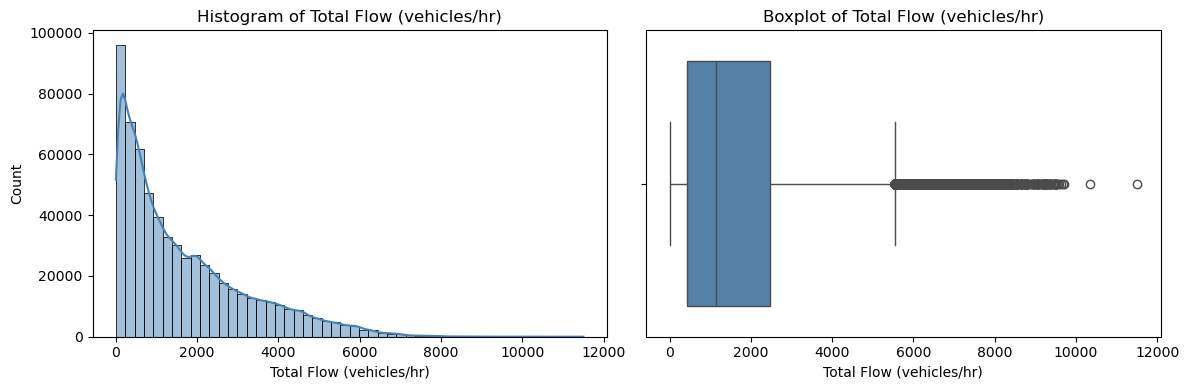

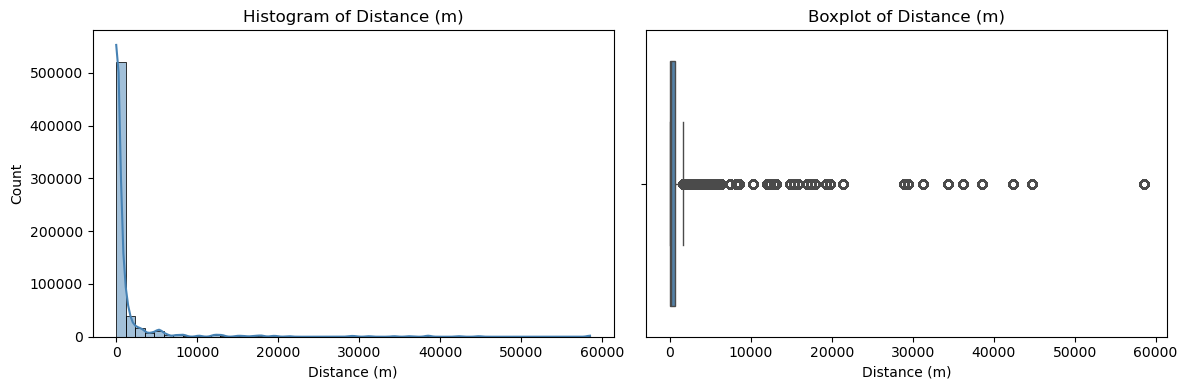

In [47]:
features_to_plot = {
    "Travel_Time_s": "Travel Time (s)",
    "Speed_mps": "Speed (m/s)",
    "Total_Flow": "Total Flow (vehicles/hr)",
    "Distance_m": "Distance (m)"
}

# Generate histogram + boxplot for each feature
for feature, label in features_to_plot.items():
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_merged[feature], bins=50, kde=True, color="steelblue")
    plt.title(f"Histogram of {label}")
    plt.xlabel(label)
    plt.ylabel("Count")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_merged[feature], color="steelblue")
    plt.title(f"Boxplot of {label}")
    plt.xlabel(label)

    plt.tight_layout()
    plt.show()

- The `Travel Time` plot displays the distribution of estimated travel times in the dataset. The histogram reveals a highly right-skewed distribution, with most values concentrated below 1000 seconds and a long tail indicating occurrences of high congestion. Outliers can be observed from the boxplot, with the majority measuring up to approximately 2800 seconds and three cases ranging from 6000 to 7400 seconds, indicating potential traffic jams over long distances.

- The `Speed` plot shows a bell-shaped distribution of speed centered around 30 m/s. However, the boxplot reveals outliers on both the low and high ends, with low-end outliers indicating slow traffic conditions and high-end outliers mostly falling between 33 and 35 m/s, with one instance exceeding 40 m/s.

- The `Total Flow` plot illustrates the number of vehicles passing through a station per hour. The histogram indicates a right-skewed distribution, with most values below 4000 vehicles per hour, and a long tail toward 10,000. The boxplot shows a median flow rate of nearly 1000 vehicles per hour and a vast number of outliers past 6000 vehicles per hour. The periods of low vehicle flow may either indicate congestion periods or off-peak hours, while the outliers may point to peak hours of travel right before congestion occurs.  

- The `Distance` plot visualizes the computed distances between successive stations based on the absolute post-mile values. The histogram shows a right-skewed distribution, with most distances falling below 5000 meters. The boxplot indicates several outliers with the majority reaching up to 20000 meters, and a few reaching between 30,000 and 60,000 meters. These may represent areas with missing stations or sensors covering a long distance.

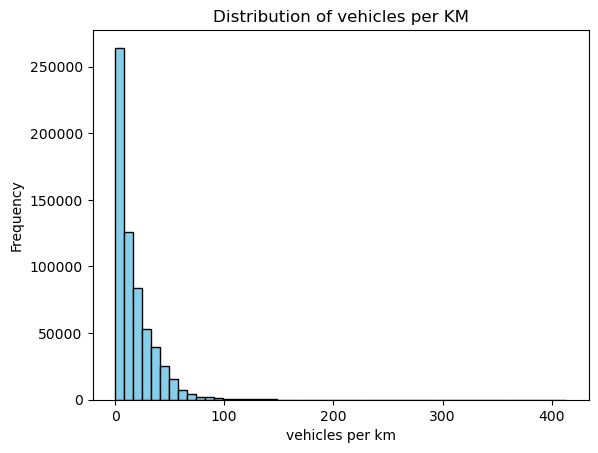

In [48]:
df_merged['Vehicles_per_KM'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of vehicles per KM")
plt.xlabel("vehicles per km")
plt.show()


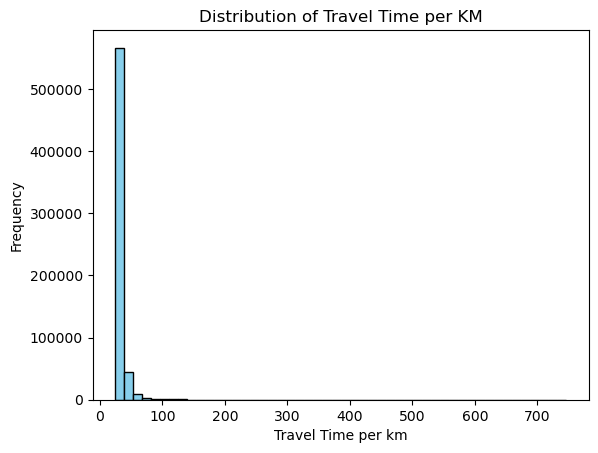

In [49]:
df_merged['Travel_Time_per_KM'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Travel Time per KM")
plt.xlabel("Travel Time per km")
plt.show()

In [50]:
print(df_merged["Vehicles_per_KM"].describe())


count    626909.000000
mean         17.070591
std          18.468588
min           0.008070
25%           4.083855
50%          10.987020
75%          24.358514
max         413.087569
Name: Vehicles_per_KM, dtype: float64


In [51]:
df_merged["Speed_mps"].describe()

count    626909.000000
mean         28.613239
std           3.177819
min           1.341120
25%          28.074112
50%          29.415232
75%          30.309312
max          41.127680
Name: Speed_mps, dtype: float64

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\3634696114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Vehicles_per_KM_bin"] = pd.cut(df_merged["Vehicles_per_KM"], bins=100)
C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\3634696114.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_avg = df_merged.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()


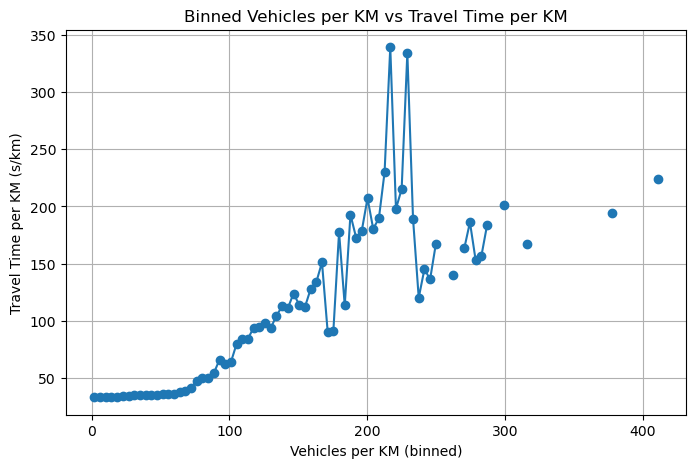

In [52]:
# Bin Vehicles_per_KM 
df_merged["Vehicles_per_KM_bin"] = pd.cut(df_merged["Vehicles_per_KM"], bins=100)

# Compute median travel time per bin
binned_avg = df_merged.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_avg["Midpoint"] = binned_avg["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Plot the trend
plt.figure(figsize=(8, 5))
plt.plot(binned_avg["Midpoint"], binned_avg["Travel_Time_per_KM"], marker='o')
plt.xlabel("Vehicles per KM (binned)")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("Binned Vehicles per KM vs Travel Time per KM")
plt.grid(True)
plt.show()

This `line plot` was way to noisy, which may have been a result of all the `ML` lane number configurations being condensed into one plot. To address this, the plots were seperated by `lane count` to highlight how they each handle congestion.

In [53]:
df_merged["Travel_Time_per_KM"].describe()

count    626909.000000
mean         35.872772
std          10.730710
min          24.314525
25%          32.993161
50%          33.995992
75%          35.620005
max         745.645431
Name: Travel_Time_per_KM, dtype: float64

In [54]:
df_merged["Vehicles_per_KM"].describe()

count    626909.000000
mean         17.070591
std          18.468588
min           0.008070
25%           4.083855
50%          10.987020
75%          24.358514
max         413.087569
Name: Vehicles_per_KM, dtype: float64

# 4. LOWESS Smoothed Graphs
The LOWESS (Locally Weighted Scatterplot Smoothing) curve was applied to highlight the overall relationship between vehicle density and travel time for `mainline (ML)` segments categorized by 2,3 and 4 lane counts.

- binned averages were applied to these plots , so they reduce computation time and are easier to interpret.
- The curves in all plots reveals a upward trend, where and increase in `vehicles per kilometer` results in higher `travel times per kilometer`, consistent with traffic flow theory.
- There are sharp rises in travel time beyond a certain vehicle density, making this smoothed curve useful for identifying the thresholds.

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\1535775731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_2lane_ml["Vehicles_per_KM"], bins=200)
C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\1535775731.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_avg_2lane = df_2lane_ml.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()


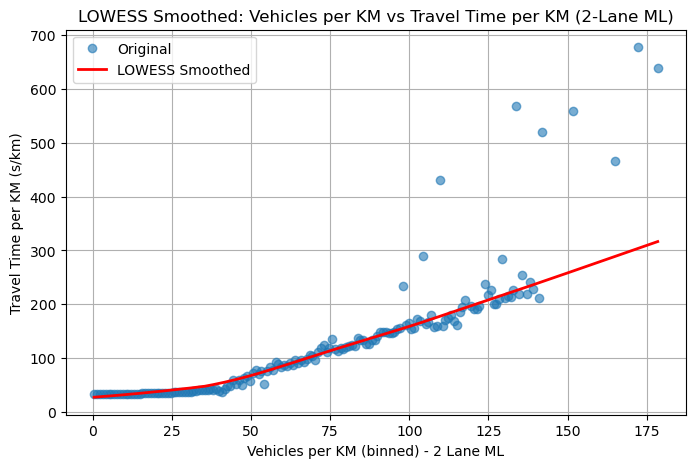

In [55]:
# Filter for 2-lane mainline segments
df_2lane_ml = df_merged[df_merged["Lanes"] == 2]

# Bin Vehicles_per_KM 
df_2lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_2lane_ml["Vehicles_per_KM"], bins=200)

# Compute median travel time per bin
binned_avg_2lane = df_2lane_ml.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_avg_2lane["Midpoint"] = binned_avg_2lane["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_smoothed = lowess(endog=binned_avg_2lane["Travel_Time_per_KM"],
                         exog=binned_avg_2lane["Midpoint"],
                         frac=0.5)

# Plot the trend
plt.figure(figsize=(8, 5))
plt.plot(binned_avg_2lane["Midpoint"], binned_avg_2lane["Travel_Time_per_KM"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Vehicles per KM (binned) - 2 Lane ML")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("LOWESS Smoothed: Vehicles per KM vs Travel Time per KM (2-Lane ML)")
plt.legend()
plt.grid(True)
plt.show()

This graph shows how `travel time per kilometer` increases nonlinearly when vehicle density increases on `2-lane mainline` segments. Travel time remains low when below `40 vehicles per kilometer`, but increases rapidly after this threshold is crossed. This plot follows traffic theory where at high vehicle congestion, `100 vehicles per kilometer` and above, the delay is increased significantly.

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\2004475795.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_3lane_ml["Vehicles_per_KM"], bins=200)
C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\2004475795.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_avg_3lane = df_3lane_ml.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()


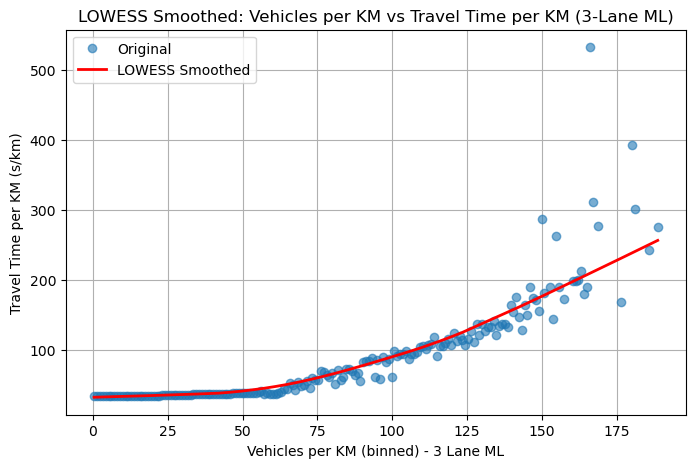

In [56]:
# Filter for 3-lane mainline segments
df_3lane_ml = df_merged[df_merged["Lanes"] == 3]

# Bin Vehicles_per_KM 
df_3lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_3lane_ml["Vehicles_per_KM"], bins=200)

# Compute median travel time per bin
binned_avg_3lane = df_3lane_ml.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_avg_3lane["Midpoint"] = binned_avg_3lane["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_smoothed_3lane = lowess(endog=binned_avg_3lane["Travel_Time_per_KM"],
                         exog=binned_avg_3lane["Midpoint"],
                         frac=0.5)  

# Plot the trend
plt.figure(figsize=(8, 5))
plt.plot(binned_avg_3lane["Midpoint"], binned_avg_3lane["Travel_Time_per_KM"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_smoothed_3lane[:, 0], lowess_smoothed_3lane[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Vehicles per KM (binned) - 3 Lane ML")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("LOWESS Smoothed: Vehicles per KM vs Travel Time per KM (3-Lane ML)")
plt.legend()
plt.grid(True)
plt.show()

This plot shows how `travel time per kilometer` increases nonlinearly when `vehicle density` increases on `3-lane mainline segments`. Travel time remains low when below `50 vehicles per kilomete`r, but increases rapidly once the `55 vehicles per kilometer` threshold is crossed. It follows traffic theory where at high vehicle congestion, 125 vehicles per kilometer and above, the delay increases rapidly.

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\1259007189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_4lane_ml["Vehicles_per_KM"], bins=200)
C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\1259007189.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_avg_4lane = df_4lane_ml.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()


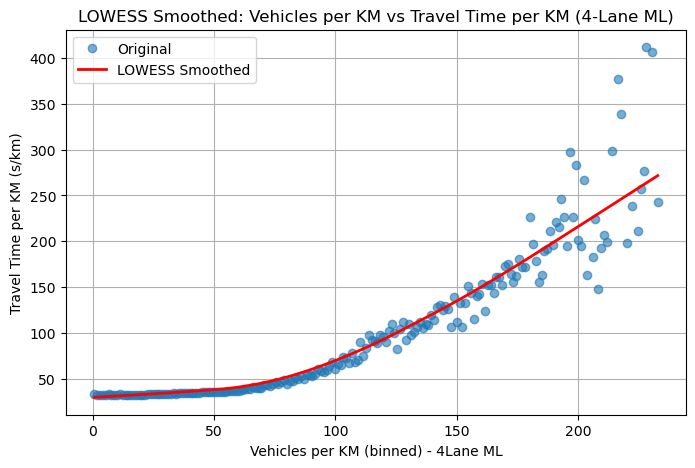

In [57]:
# Filter for 4-lane mainline segments
df_4lane_ml = df_merged[df_merged["Lanes"] == 4]

# Bin Vehicles_per_KM 
df_4lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_4lane_ml["Vehicles_per_KM"], bins=200)

# Compute median travel time per bin
binned_avg_4lane = df_4lane_ml.groupby("Vehicles_per_KM_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_avg_4lane["Midpoint"] = binned_avg_4lane["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_smoothed = lowess(endog=binned_avg_4lane["Travel_Time_per_KM"],
                         exog=binned_avg_4lane["Midpoint"],
                         frac=0.5)  

# Plot the trend
plt.figure(figsize=(8, 5))
plt.plot(binned_avg_4lane["Midpoint"], binned_avg_4lane["Travel_Time_per_KM"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Vehicles per KM (binned) - 4Lane ML")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("LOWESS Smoothed: Vehicles per KM vs Travel Time per KM (4-Lane ML)")
plt.legend()
plt.grid(True)
plt.show()

This graph shows how `travel time per kilometer` increases nonlinearly when `vehicle density` increases on `4-lane mainline` segments. Travel time remains low when below roughly `70 vehicles per kilometer`, but increases rapidly after this threshold is crossed. This plot follows traffic theory where at high vehicle congestion, `150 vehicles per kilometer` and above, the delay is increased.

# 5. Additional Plots for Traffic Flow
Additional plots were created for: 
- `Vehicle per kilometer (Veh/km) vs. Speed (km/h)` 
- `Speed (km/h) vs. Travel time per kilometer (s/km)`

While the previous plots showed us the relationship between `density` and `travel time`, understanding how density relates to speed and how speed relates to travel time is crucial for forming the foundation of this model. Hence, plots were created for these using LOWESS to fit to overall, nonlinear relationship.

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\3900599745.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_tt_2lane = df_2lane_ml.groupby("Speed_bin")["Travel_Time_per_KM"].median().reset_index()


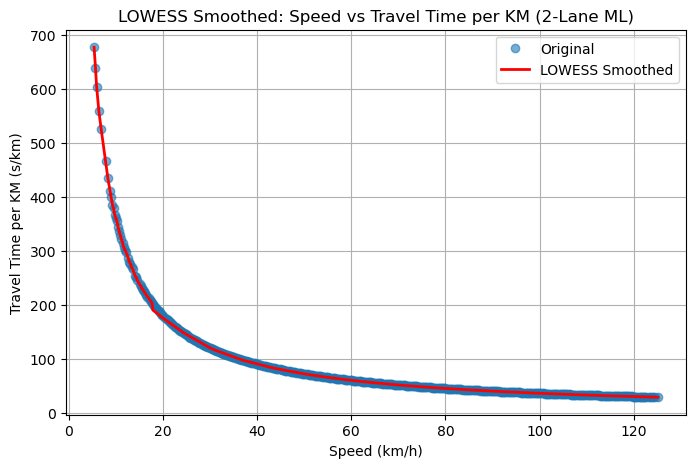

In [58]:
# Filter for 2-lane mainline segments
df_2lane_ml = df_merged[df_merged["Lanes"] == 2].copy()

# Bin speed
df_2lane_ml["Speed_bin"] = pd.cut(df_2lane_ml["Speed_kph"], bins=500)

# Compute median travel time per bin
binned_tt_2lane = df_2lane_ml.groupby("Speed_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_tt_2lane["Midpoint"] = binned_tt_2lane["Speed_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_speed_vs_travel_2lane = lowess(
    endog=binned_tt_2lane["Travel_Time_per_KM"],
    exog=binned_tt_2lane["Midpoint"],
    frac=0.1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(binned_tt_2lane["Midpoint"], binned_tt_2lane["Travel_Time_per_KM"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_speed_vs_travel_2lane[:, 0], lowess_speed_vs_travel_2lane[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Speed (km/h)")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("LOWESS Smoothed: Speed vs Travel Time per KM (2-Lane ML)")
plt.grid(True)
plt.legend()
plt.show()

This figure illustrates the inverse relationship between speed and travel time per kilometer on 2-lane ML segments, where travel time rapidly increases as speed decreases. LOWESS Smoothed: `Vehicles per KM vs Travel Time per KM (2-Lane ML)` plot had a speed of approximately `80 km/h` at the `40 vehicle per kilometer` threshold but dropped rapidly once this threshold was crossed. This plot complements that observation where the travel time increases significantly as the speed drops below that mark, notably when below `40 kilometers per hour`.

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\366643306.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_2 = df_2lane_ml.groupby("Vehicles_per_KM_bin")["Speed_kph"].median().reset_index()


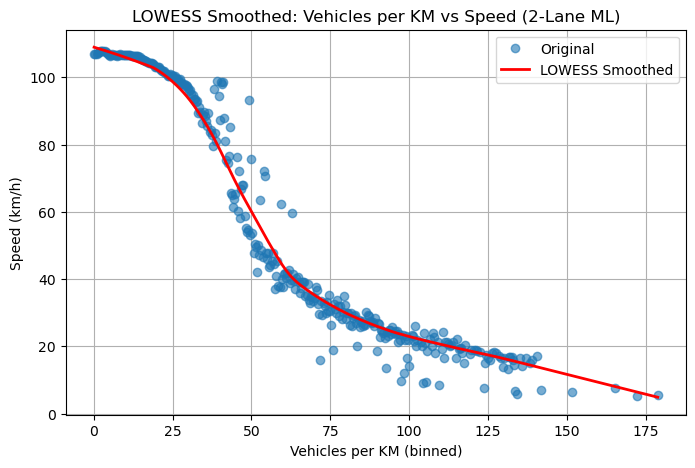

In [59]:
# Bin Vehicles_per_KM 
df_2lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_2lane_ml["Vehicles_per_KM"], bins=500)

# Compute median speed per bin
binned_data_2 = df_2lane_ml.groupby("Vehicles_per_KM_bin")["Speed_kph"].median().reset_index()
binned_data_2["Midpoint"] = binned_data_2["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_smooth_2 = lowess(
    endog=binned_data_2["Speed_kph"],
    exog=binned_data_2["Midpoint"],
    frac=0.3)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(binned_data_2["Midpoint"], binned_data_2["Speed_kph"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_smooth_2[:, 0], lowess_smooth_2[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Vehicles per KM (binned)")
plt.ylabel("Speed (km/h)")
plt.title("LOWESS Smoothed: Vehicles per KM vs Speed (2-Lane ML)")
plt.grid(True)
plt.legend()
plt.show()



This graph demonstrates the inverse relationship between `vehicle density` and `speed`. As observed in `Vehicles per KM vs Travel Time per KM (2-Lane ML)`, at `40 vehicles per kilometer`, travel time rapidly increases. This scatterplot supports that observation, showing a sharp drop in speed after that threshold is crossed. 

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\1167012659.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_tt_4lane = df_4lane_ml.groupby("Speed_bin")["Travel_Time_per_KM"].median().reset_index()


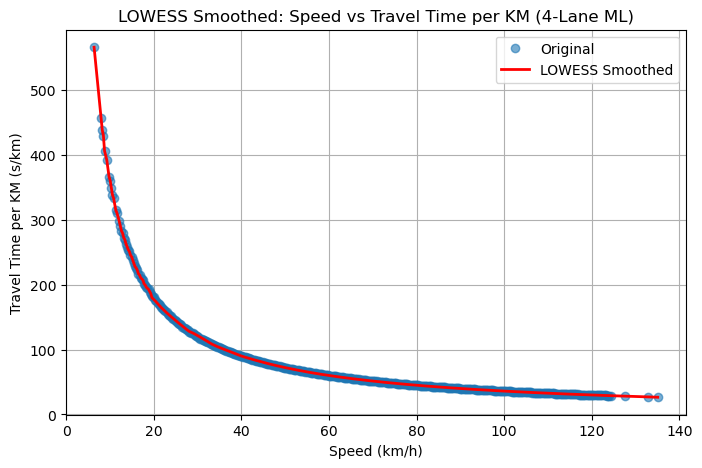

In [60]:
# Filter for 4-lane mainline segments
df_4lane_ml = df_merged[df_merged["Lanes"] == 4].copy()

# Bin speed 
df_4lane_ml["Speed_bin"] = pd.cut(df_4lane_ml["Speed_kph"], bins=500)

# Compute average travel time per bin
binned_tt_4lane = df_4lane_ml.groupby("Speed_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_tt_4lane["Midpoint"] = binned_tt_4lane["Speed_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_speed_vs_travel_4lane = lowess(
    endog=binned_tt_4lane["Travel_Time_per_KM"],
    exog=binned_tt_4lane["Midpoint"],
    frac=0.1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(binned_tt_4lane["Midpoint"], binned_tt_4lane["Travel_Time_per_KM"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_speed_vs_travel_4lane[:, 0], lowess_speed_vs_travel_4lane[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Speed (km/h)")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("LOWESS Smoothed: Speed vs Travel Time per KM (4-Lane ML)")
plt.grid(True)
plt.legend()
plt.show()

This figure illustrates the inverse relationship between `speed` and `travel time per kilometer` on `4-lane ML segments`, where `travel time` rapidly increases as `speed` decreases. `LOWESS Smoothed: Vehicles per KM vs Speed (4-Lane ML)` had a speed of approximately `82 km/h` at the `70 vehicle per kilometer` threshold, but dropped rapidly once this threshold was crossed. This plot complements that observation where the travel time increases significantly as the speed drops below that mark, notably when below `40 kilometers per hour`.

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\2174612797.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_4 = df_4lane_ml.groupby("Vehicles_per_KM_bin")["Speed_kph"].median().reset_index()


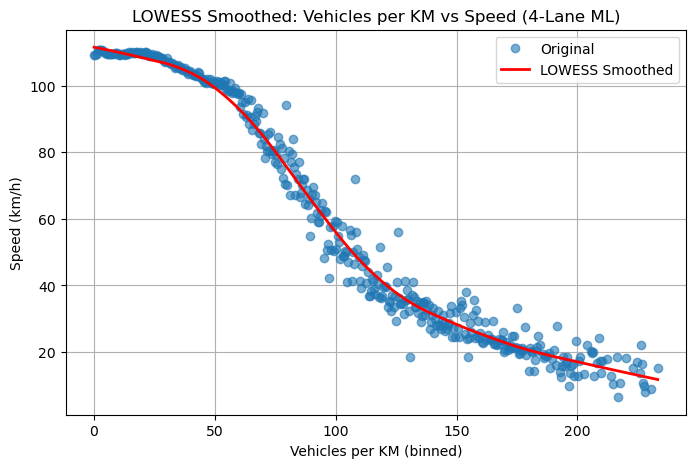

In [61]:
# Bin Vehicles_per_KM 
df_4lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_4lane_ml["Vehicles_per_KM"], bins=500)

# Compute mean speed per bin
binned_data_4 = df_4lane_ml.groupby("Vehicles_per_KM_bin")["Speed_kph"].median().reset_index()
binned_data_4["Midpoint"] = binned_data_4["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_smooth_4 = lowess(
    endog=binned_data_4["Speed_kph"],
    exog=binned_data_4["Midpoint"],
    frac=0.3)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(binned_data_4["Midpoint"], binned_data_4["Speed_kph"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_smooth_4[:, 0], lowess_smooth_4[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Vehicles per KM (binned)")
plt.ylabel("Speed (km/h)")
plt.title("LOWESS Smoothed: Vehicles per KM vs Speed (4-Lane ML)")
plt.grid(True)
plt.legend()
plt.show()


This graph demonstrates the inverse relationship between `vehicle density` and `speed` on `4-lane ML segments`. As observed in `LOWESS Smoothed: Vehicles per KM vs Travel Time per KM (4-Lane ML)`, at roughly 60 vehicles per kilometer, travel time rapidly increases. This scatterplot supports that observation, showing a sharp drop in speed after that threshold is crossed. 

In [62]:
df_merged.describe()

,Timestamp,Station_ID,District,Freeway,Station_Length,Total_Flow,Avg_Occupancy,Avg_Speed,Absolute_Postmile,Latitude,Longitude,Lanes,Distance_m,Speed_mps,Travel_Time_s,Hour,Day_of_Week,Speed_kph,Vehicles_per_KM,Travel_Time_per_KM
count,626909,6.269090e+05,626909.0,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000,626909.000000
mean,2025-01-16 11:59:01.065130496,1.529013e+06,3.0,64.396924,1.206322,1656.835708,0.043195,64.005992,170.954087,38.770253,-121.283085,2.733795,1435.067258,28.613239,51.212436,11.534416,2.999612,103.007660,17.070591,35.872772
min,2025-01-01 00:00:00,3.085110e+05,3.0,5.000000,0.001000,1.000000,0.000000,3.000000,0.111000,38.129763,-122.214892,1.000000,1.609340,1.341120,0.045226,0.000000,0.000000,4.828032,0.008070,24.314525
25%,2025-01-08 18:00:00,3.160630e+05,3.0,50.000000,0.383000,429.000000,0.014400,62.800000,34.775000,38.574905,-121.522183,2.000000,11.265380,28.074112,0.414985,6.000000,1.000000,101.066803,4.083855,32.993161
50%,2025-01-16 12:00:00,3.190160e+05,3.0,65.000000,0.623000,1144.000000,0.034800,65.800000,97.211000,38.657724,-121.394106,3.000000,80.467000,29.415232,2.756750,12.000000,3.000000,105.894835,10.987020,33.995992
75%,2025-01-24 06:00:00,3.055041e+06,3.0,80.000000,1.466000,2473.000000,0.061600,67.800000,293.046000,38.851357,-121.179006,3.000000,679.141480,30.309312,24.406719,18.000000,5.000000,109.113523,24.358514,35.620005
max,2025-01-31 23:00:00,3.900023e+06,3.0,505.000000,5.000000,11506.000000,0.717900,92.000000,621.401000,39.789571,-119.949361,6.000000,58531.695800,41.127680,7494.555285,23.000000,6.000000,148.059648,413.087569,745.645431
std,NaN,1.407473e+06,0.0,38.089137,1.290741,1554.835935,0.039177,7.108578,171.500690,0.327286,0.437767,1.077038,5236.202100,3.177819,185.058804,6.905335,1.917769,11.440147,18.468588,10.730710


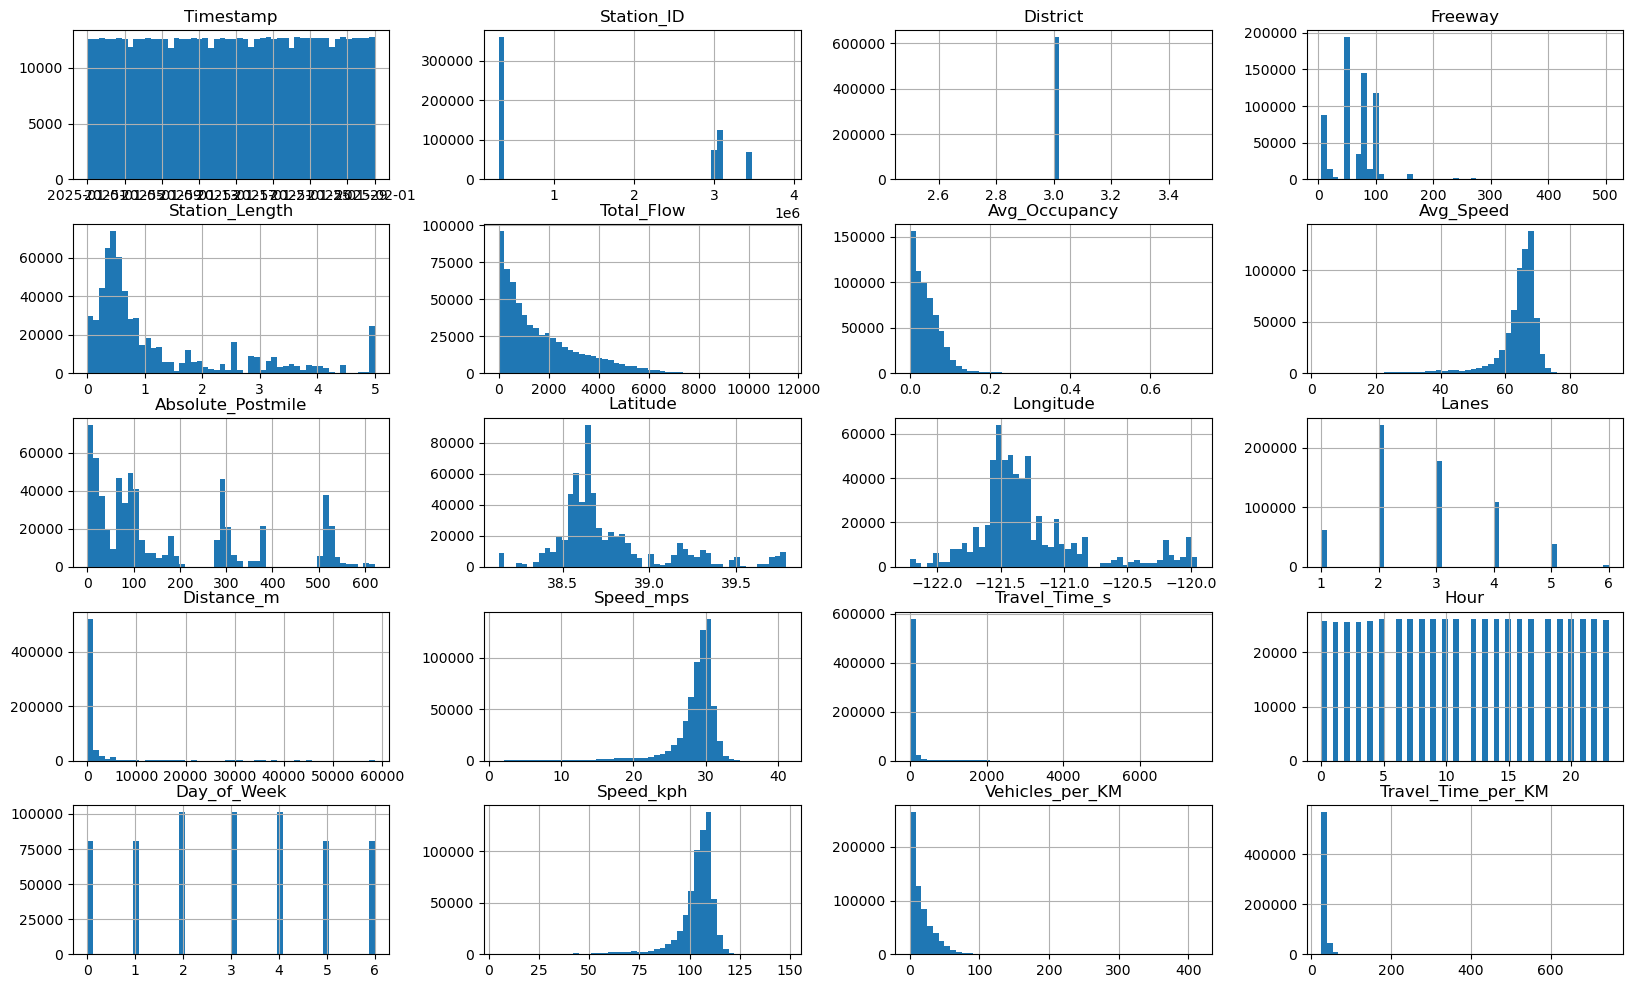

In [63]:
df_merged.hist(figsize=(20, 12), bins=50)
plt.show()

# 6. 3-Lane segments exploration for Speed(km/h), Travel time per km (s/km) and vehicle desnity(Veh/km)

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\2511946240.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_speed_3lane = df_3lane_ml.groupby("Vehicles_per_KM_bin")["Speed_kph"].median().reset_index()


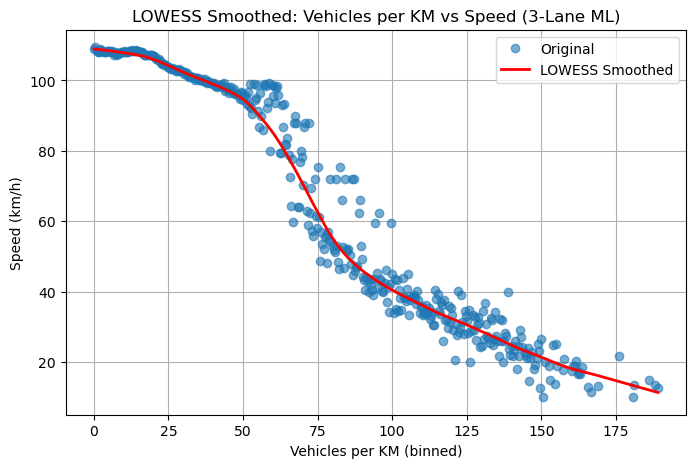

In [64]:
# Filter for 3-lane mainline segments
df_3lane_ml = df_merged[df_merged["Lanes"] == 3].copy()

# Bin Vehicles_per_KM 
df_3lane_ml["Vehicles_per_KM_bin"] = pd.cut(df_3lane_ml["Vehicles_per_KM"], bins=500)

# Compute average speed per bin
binned_speed_3lane = df_3lane_ml.groupby("Vehicles_per_KM_bin")["Speed_kph"].median().reset_index()

# Midpoints of bins for plotting
binned_speed_3lane["Midpoint"] = binned_speed_3lane["Vehicles_per_KM_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_density_vs_speed_3lane = lowess(
    endog=binned_speed_3lane["Speed_kph"],
    exog=binned_speed_3lane["Midpoint"],
    frac=0.2)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(binned_speed_3lane["Midpoint"], binned_speed_3lane["Speed_kph"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_density_vs_speed_3lane[:, 0], lowess_density_vs_speed_3lane[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Vehicles per KM (binned)")
plt.ylabel("Speed (km/h)")
plt.title("LOWESS Smoothed: Vehicles per KM vs Speed (3-Lane ML)")
plt.grid(True)
plt.legend()
plt.show()

This plots demonstrates the inverse relationship between `vehicle density` and `speed`. As observed in `LOWESS Smoothed: Vehicles per KM vs Travel Time per KM (3-Lane ML)`, at `55 vehicles per kilometer`, `travel time` rapidly increases. This scatterplot supports that observation, where there is a sharp drop in speed around that threshold. 

C:\Users\dillo\AppData\Local\Temp\ipykernel_33824\3348486906.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_tt_3lane = df_3lane_ml.groupby("Speed_bin")["Travel_Time_per_KM"].median().reset_index()


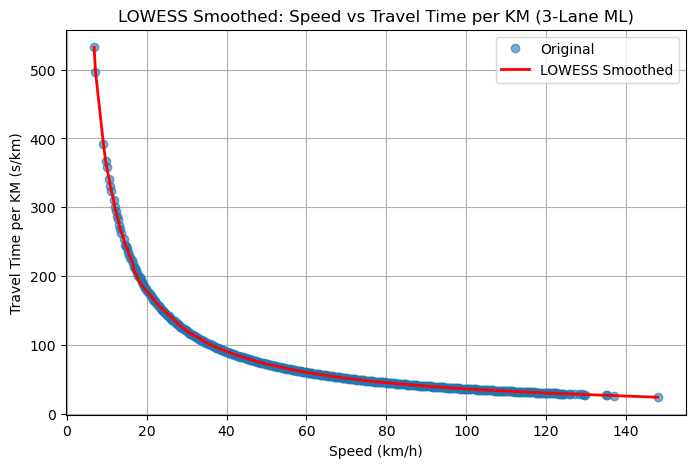

In [65]:
# Filter for 3-lane mainline segments
df_3lane_ml = df_merged[df_merged["Lanes"] == 3].copy()

# Bin speed 
df_3lane_ml["Speed_bin"] = pd.cut(df_3lane_ml["Speed_kph"], bins=500)

# Compute average travel time per bin
binned_tt_3lane = df_3lane_ml.groupby("Speed_bin")["Travel_Time_per_KM"].median().reset_index()

# Midpoints of bins for plotting
binned_tt_3lane["Midpoint"] = binned_tt_3lane["Speed_bin"].apply(lambda x: x.mid)

# Apply LOWESS smoothing
lowess_speed_vs_travel_3lane = lowess(
    endog=binned_tt_3lane["Travel_Time_per_KM"],
    exog=binned_tt_3lane["Midpoint"],
    frac=0.1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(binned_tt_3lane["Midpoint"], binned_tt_3lane["Travel_Time_per_KM"], 'o', alpha=0.6, label="Original")
plt.plot(lowess_speed_vs_travel_3lane[:, 0], lowess_speed_vs_travel_3lane[:, 1], 'r-', linewidth=2, label="LOWESS Smoothed")
plt.xlabel("Speed (km/h)")
plt.ylabel("Travel Time per KM (s/km)")
plt.title("LOWESS Smoothed: Speed vs Travel Time per KM (3-Lane ML)")
plt.grid(True)
plt.legend()
plt.show()

This plot illustrates the inverse relationship between `speed` and `travel time per kilometer` on `3-lane ML segments`, where travel time rapidly increases as speed decreases. `LOWESS Smoothed: Vehicles per KM vs Speed (3-Lane ML)` had a speed of approximately `90 km/h` at the 55 vehicle per kilometer threshold but dropped rapidly once that threshold was crossed. This plot complements that observation where the travel time increases significantly as the speed drops below that mark, notably when below `40 kilometers per hour`. 

# 7. Baseline Values

As we now have a foundation for the model to assess the relationships between traffic flow metrics ( `Density`, `Speed`, and `Travel Time`), the LOWESS smoothed plots will be used to interpolate the corresponding `density` and `travel time` values for and estimated `speed` provided by `WAZE`.

This code helps simulate:

- How much `time` (in seconds per km) it takes to travel at a given speed.

- What `vehicle density` (vehicles/km) is typically associated with that speed.

This information is essential to later simulate congestion impacts under HOV scenarios that reduce traffic congestion.

## 7.1 Arima to POS (AM)

In [66]:
# Target speed (km/h)
target_speed1_1 = 18.6

# Get travel time per KM from speed vs travel time graph
closest_index_tt1_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed1_1)).argmin()
travel_time_at_18_6_kph = lowess_speed_vs_travel_3lane[closest_index_tt1_1, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density1_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed1_1)).argmin()
vehicle_density_at_18_6_kph = lowess_density_vs_speed_3lane[closest_index_density1_1, 0]

print(f"At 18.6 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_18_6_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_18_6_kph:.2f} vehicles/km")


At 18.6 km/h:
Estimated Travel Time per KM = 189.13 s/km
Estimated Vehicle Density = 157.57 vehicles/km


In [67]:
# Target speed (km/h)
target_speed1_2 = 42.9

# Get travel time per KM from speed vs travel time graph
closest_index_tt1_2 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed1_2)).argmin()
travel_time_at_42_9_kph = lowess_speed_vs_travel_3lane[closest_index_tt1_2, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density1_2 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed1_2)).argmin()
vehicle_density_at_42_9_kph = lowess_density_vs_speed_3lane[closest_index_density1_2, 0]

print(f"At 42.9 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_42_9_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_42_9_kph:.2f} vehicles/km")

At 42.9 km/h:
Estimated Travel Time per KM = 84.49 s/km
Estimated Vehicle Density = 95.15 vehicles/km


## 7.2 San Fernando to POS (AM)

In [68]:
# Target speed (km/h)
target_speed2_1 = 36.7
# Get travel time per KM from speed vs travel time graph
closest_index_tt2_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed2_1)).argmin()
travel_time_at_36_7_kph = lowess_speed_vs_travel_3lane[closest_index_tt2_1, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density2_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed2_1)).argmin()
vehicle_density_at_36_7_kph = lowess_density_vs_speed_3lane[closest_index_density2_1, 0]

print(f"At 36.7 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_36_7_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_36_7_kph:.2f} vehicles/km")

At 36.7 km/h:
Estimated Travel Time per KM = 98.47 s/km
Estimated Vehicle Density = 108.77 vehicles/km


## 7.3 POS to Arima (PM)

In [69]:
# Target speed (km/h)
target_speed3_1 = 28
# Get travel time per KM from speed vs travel time graph
closest_index_tt3_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed3_1)).argmin()
travel_time_at_28_kph = lowess_speed_vs_travel_3lane[closest_index_tt3_1, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density3_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed3_1)).argmin()
vehicle_density_at_28_kph = lowess_density_vs_speed_3lane[closest_index_density3_1, 0]

print(f"At 28 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_28_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_28_kph:.2f} vehicles/km")

At 28 km/h:
Estimated Travel Time per KM = 129.13 s/km
Estimated Vehicle Density = 131.85 vehicles/km


In [70]:
# Target speed (km/h)
target_speed3_2 = 14.4
# Get travel time per KM from speed vs travel time graph
closest_index_tt3_2 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed3_2)).argmin()
travel_time_at_14_4_kph = lowess_speed_vs_travel_3lane[closest_index_tt3_2, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density3_2 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed3_2)).argmin()
vehicle_density_at_14_4_kph = lowess_density_vs_speed_3lane[closest_index_density3_2, 0]

print(f"At 14.4 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_14_4_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_14_4_kph:.2f} vehicles/km")

At 14.4 km/h:
Estimated Travel Time per KM = 245.82 s/km
Estimated Vehicle Density = 176.11 vehicles/km


In [71]:
# Target speed (km/h)
target_speed3_3 = 31.7
# Get travel time per KM from speed vs travel time graph
closest_index_tt3_3 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed3_3)).argmin()
travel_time_at_31_7_kph = lowess_speed_vs_travel_3lane[closest_index_tt3_3, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density3_3 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed3_3)).argmin()
vehicle_density_at_31_7_kph = lowess_density_vs_speed_3lane[closest_index_density3_3, 0]

print(f"At 31.7 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_31_7_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_31_7_kph:.2f} vehicles/km")

At 31.7 km/h:
Estimated Travel Time per KM = 113.93 s/km
Estimated Vehicle Density = 121.64 vehicles/km


## 7.4 POS to San Fernando (PM)

In [72]:
# Target speed (km/h)
target_speed4_1 = 38
# Get travel time per KM from speed vs travel time graph
closest_index_tt4_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed4_1)).argmin()
travel_time_at_38_kph = lowess_speed_vs_travel_3lane[closest_index_tt4_1, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density4_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed4_1)).argmin()
vehicle_density_at_38_kph = lowess_density_vs_speed_3lane[closest_index_density4_1, 0]

print(f"At 38 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_38_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_38_kph:.2f} vehicles/km")

At 38 km/h:
Estimated Travel Time per KM = 95.05 s/km
Estimated Vehicle Density = 105.75 vehicles/km


In [73]:
# Target speed (km/h)
target_speed4_2 = 26.9
# Get travel time per KM from speed vs travel time graph
closest_index_tt4_2 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed4_2)).argmin()
travel_time_at_26_9_kph = lowess_speed_vs_travel_3lane[closest_index_tt4_2, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density4_2 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed4_2)).argmin()
vehicle_density_at_26_9_kph = lowess_density_vs_speed_3lane[closest_index_density4_2, 0]

print(f"At 26.9 km/h:")
print(f"Estimated Travel Time per KM = {travel_time_at_26_9_kph:.2f} s/km")
print(f"Estimated Vehicle Density = {vehicle_density_at_26_9_kph:.2f} vehicles/km")

At 26.9 km/h:
Estimated Travel Time per KM = 135.63 s/km
Estimated Vehicle Density = 134.50 vehicles/km


# 8. HOV effects

To evaluate the effects of an HOV lane, a `30%` reduction in `vehicle density` was applied where the `LOWESS` smoothed relationship between `density` and `speed` was used to `interpolate` the expected `speed` for the reduced congestion. This helps estimate how traffic may flow with increased carpooling.


## 8.1 Morning Peak

In [74]:
# Extract the X (density) and Y (speed) values from the LOWESS plots
x_vals = lowess_density_vs_speed_3lane[:, 0]  # Density (vehicles/km)
y_vals = lowess_density_vs_speed_3lane[:, 1]  # Speed (km/h)

# Target vehicle density
target_density1 = 111
target_density2 = 67
target_density3 = 76

# Interpolate to find the corresponding speed
corresponding_speed1 = np.interp(target_density1, x_vals, y_vals)
corresponding_speed2 = np.interp(target_density2, x_vals, y_vals)
corresponding_speed3 = np.interp(target_density3, x_vals, y_vals)

print(f"Estimated speed at {target_density1} vehicles/km: {corresponding_speed1:.2f} km/h")
print(f"Estimated speed at {target_density2} vehicles/km: {corresponding_speed2:.2f} km/h")
print(f"Estimated speed at {target_density3} vehicles/km: {corresponding_speed3:.2f} km/h")

Estimated speed at 111 vehicles/km: 35.68 km/h
Estimated speed at 67 vehicles/km: 75.39 km/h
Estimated speed at 76 vehicles/km: 61.05 km/h


### 8.1.1 Arima to POS
Using the `interpolated speeds` form the `morning peak`, the correspodning `density` and `travel times` were also interpolated to see their behaviour to the HOV simulation

In [75]:
# Target speed (km/h)
target_speed5_1 = 35.68

# Gets the travel time per KM from speed vs travel time graph
closest_index_tt5_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed5_1)).argmin()
travel_time_at_35_68_kph = lowess_speed_vs_travel_3lane[closest_index_tt5_1, 1]

# Gets the vehicle density from speed vs vehicle density graph
closest_index_density5_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed5_1)).argmin()
vehicle_density_at_35_68_kph = lowess_density_vs_speed_3lane[closest_index_density5_1, 0]

print(f"At 35.68 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_35_68_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_35_68_kph:.2f} vehicles/km")

At 35.68 km/h:
Estimated Travel Time per KM ≈ 101.03 s/km
Estimated Vehicle Density ≈ 111.04 vehicles/km


In [76]:
# Target speed (km/h)
target_speed5_2 = 75.39

# Gets the travel time per KM from speed vs travel time graph
closest_index_tt5_2 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed5_2)).argmin()
travel_time_at_75_39_kph = lowess_speed_vs_travel_3lane[closest_index_tt5_2, 1]

# Gets the vehicle density from speed vs vehicle density graph
closest_index_density5_2 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed5_2)).argmin()
vehicle_density_at_75_39_kph = lowess_density_vs_speed_3lane[closest_index_density5_2, 0]

print(f"At 75.39 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_75_39_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_75_39_kph:.2f} vehicles/km")

At 75.39 km/h:
Estimated Travel Time per KM ≈ 47.86 s/km
Estimated Vehicle Density ≈ 67.16 vehicles/km


### 8.1.2 San Fernando to POS

In [77]:
# Target speed (km/h)
target_speed6_1 = 61.05

# Gets the travel time per KM from speed vs travel time graph
closest_index_tt6_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed6_1)).argmin()
travel_time_at_61_05_kph = lowess_speed_vs_travel_3lane[closest_index_tt6_1, 1]

# Gets the vehicle density from speed vs vehicle density graph
closest_index_density6_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed6_1)).argmin()
vehicle_density_at_61_05_kph = lowess_density_vs_speed_3lane[closest_index_density6_1, 0]

print(f"At 61.05 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_61_05_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_61_05_kph:.2f} vehicles/km")

At 61.05 km/h:
Estimated Travel Time per KM ≈ 58.95 s/km
Estimated Vehicle Density ≈ 75.86 vehicles/km


## 8.2 Afternoon Peak 

In [78]:
# Extract the X (density) and Y (speed) values from the LOWESS plots
x_vals = lowess_density_vs_speed_3lane[:, 0]  # Density (vehicles/km)
y_vals = lowess_density_vs_speed_3lane[:, 1]  # Speed (km/h)

# Target vehicle density
target_density4 = 92
target_density5 = 123
target_density6 = 85
target_density7 = 74
target_density8 = 95

# Interpolate to find the corresponding speed
corresponding_speed4 = np.interp(target_density4, x_vals, y_vals)
corresponding_speed5 = np.interp(target_density5, x_vals, y_vals)
corresponding_speed6 = np.interp(target_density6, x_vals, y_vals)
corresponding_speed7 = np.interp(target_density7, x_vals, y_vals)
corresponding_speed8 = np.interp(target_density8, x_vals, y_vals)

print(f"Estimated speed at {target_density4} vehicles/km: {corresponding_speed4:.2f} km/h")
print(f"Estimated speed at {target_density5} vehicles/km: {corresponding_speed5:.2f} km/h")
print(f"Estimated speed at {target_density6} vehicles/km: {corresponding_speed6:.2f} km/h")
print(f"Estimated speed at {target_density7} vehicles/km: {corresponding_speed7:.2f} km/h")
print(f"Estimated speed at {target_density8} vehicles/km: {corresponding_speed8:.2f} km/h")

Estimated speed at 92 vehicles/km: 44.68 km/h
Estimated speed at 123 vehicles/km: 31.27 km/h
Estimated speed at 85 vehicles/km: 49.82 km/h
Estimated speed at 74 vehicles/km: 64.18 km/h
Estimated speed at 95 vehicles/km: 42.95 km/h


### 8.2.1 POS to Arima

Using the `interpolated speeds` form the `afternoon peak`, the correspodning `density` and `travel times` were also interpolated to see their behaviour to the HOV simulation

In [79]:
# Target speed (km/h)
target_speed7_1 = 44.68

# Gets the travel time per KM from speed vs travel time graph
closest_index_tt7_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed7_1)).argmin()
travel_time_at_44_68_kph = lowess_speed_vs_travel_3lane[closest_index_tt7_1, 1]

# Gets the vehicle density from speed vs vehicle density graph
closest_index_density7_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed7_1)).argmin()
vehicle_density_at_44_68_kph = lowess_density_vs_speed_3lane[closest_index_density7_1, 0]

print(f"At 44.68 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_44_68_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_44_68_kph:.2f} vehicles/km")

At 44.68 km/h:
Estimated Travel Time per KM ≈ 80.83 s/km
Estimated Vehicle Density ≈ 92.13 vehicles/km


In [80]:
# Target speed (km/h)
target_speed7_2 = 31.27

# Gets the travel time per KM from speed vs travel time graph
closest_index_tt7_2 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed7_2)).argmin()
travel_time_at_31_27_kph = lowess_speed_vs_travel_3lane[closest_index_tt7_2, 1]

# Gets the vehicle density from speed vs vehicle density graph
closest_index_density7_2 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed7_2)).argmin()
vehicle_density_at_31_27_kph = lowess_density_vs_speed_3lane[closest_index_density7_2, 0]

print(f"At 31.27 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_31_27_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_31_27_kph:.2f} vehicles/km")

At 31.27 km/h:
Estimated Travel Time per KM ≈ 115.74 s/km
Estimated Vehicle Density ≈ 123.15 vehicles/km


In [81]:
# Target speed (km/h)
target_speed7_3 = 49.82

# Get travel time per KM from speed vs travel time graph
closest_index_tt7_3 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed7_3)).argmin()
travel_time_at_49_82_kph = lowess_speed_vs_travel_3lane[closest_index_tt7_3, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density7_3 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed7_3)).argmin()
vehicle_density_at_49_82_kph = lowess_density_vs_speed_3lane[closest_index_density7_3, 0]

print(f"At 49.82 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_49_82_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_49_82_kph:.2f} vehicles/km")

At 49.82 km/h:
Estimated Travel Time per KM ≈ 72.38 s/km
Estimated Vehicle Density ≈ 84.94 vehicles/km


### 8.2.2 POS to San Fernando

In [82]:
# Target speed (km/h)
target_speed8_1 = 64.18

# Get travel time per KM from speed vs travel time graph
closest_index_tt8_1 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed8_1)).argmin()
travel_time_at_64_18_kph = lowess_speed_vs_travel_3lane[closest_index_tt8_1, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density8_1 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed8_1)).argmin()
vehicle_density_at_64_18_kph = lowess_density_vs_speed_3lane[closest_index_density8_1, 0]

print(f"At 64.18 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_64_18_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_64_18_kph:.2f} vehicles/km")

At 64.18 km/h:
Estimated Travel Time per KM ≈ 56.08 s/km
Estimated Vehicle Density ≈ 73.97 vehicles/km


In [83]:
# Target speed (km/h)
target_speed8_2 = 42.95

# Get travel time per KM from speed vs travel time graph
closest_index_tt8_2 = (np.abs(lowess_speed_vs_travel_3lane[:, 0] - target_speed8_2)).argmin()
travel_time_at_42_95_kph = lowess_speed_vs_travel_3lane[closest_index_tt8_2, 1]

# Get vehicle density from speed vs vehicle density graph
closest_index_density8_2 = (np.abs(lowess_density_vs_speed_3lane[:, 1] - target_speed8_2)).argmin()
vehicle_density_at_42_95_kph = lowess_density_vs_speed_3lane[closest_index_density8_2, 0]

print(f"At 42.95 km/h:")
print(f"Estimated Travel Time per KM ≈ {travel_time_at_42_95_kph:.2f} s/km")
print(f"Estimated Vehicle Density ≈ {vehicle_density_at_42_95_kph:.2f} vehicles/km")

At 42.95 km/h:
Estimated Travel Time per KM ≈ 83.95 s/km
Estimated Vehicle Density ≈ 95.15 vehicles/km
